In [87]:
import pandas as pd
import numpy as np

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import filters, morphology, measure, color
from skimage.measure import regionprops
from tifffile import imread, imsave

import glob

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from skimage import measure

from scipy.spatial.distance import pdist

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['font.size'] = 20
plt.style.use('seaborn-v0_8-ticks')

In [88]:


color_palette = {'DMSO' : '#4d4d4d',
                 'ARYL_AG':'#F8766D', 'ARYL_INH':"#F8766D50",
                 'ANDR_AG':'#fccb17', 'ANDR_INH':'#C49A0050',  
                 "ESTR_AG": '#53B400', "ESTR_INH": '#53B40050', 
                 'GC_AG' : '#00C094', 'GC_INH' : '#00C09450',
                 'LX_AG' : '#00B6EB', 'LX_INH' : '#00B6EB50', 
                 'RET_AG' : '#A58AFF', 'RET_INH' : '#A58AFF50', 
                 'THYR_AG' : '#FB61D7', 'THYR_INH' : '#FB61D750'
}

import matplotlib.colors as mcolors

def hex_to_rgba(hex_color):
    """Convert hex color to RGBA. Supports 8-digit hex with alpha."""
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 6:
        return mcolors.to_rgba('#' + hex_color)
    elif len(hex_color) == 8:
        rgb = hex_color[:6]
        alpha = int(hex_color[6:], 16) / 255
        return (*mcolors.to_rgb('#' + rgb), alpha)
    else:
        raise ValueError(f"Invalid hex color: #{hex_color}")

def hex_to_rgba_string(hex_color):
    """Convert hex color to rgba() string for Seaborn."""
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 6:
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return f'rgba({r}, {g}, {b}, 1.0)'
    elif len(hex_color) == 8:
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        a = int(hex_color[6:], 16) / 255
        return f'rgba({r}, {g}, {b}, {a:.3f})'
    else:
        raise ValueError(f"Invalid hex color: #{hex_color}")
    
# Convert all to RGBA
color_palette_rgba = {k: hex_to_rgba(v) for k, v in color_palette.items()}
color_palette_rgba_str = {k: hex_to_rgba_string(v) for k, v in color_palette.items()}

color_palette_expanded = {'DMSO_CTL08A': '#cacaca',
 'DMSO_CTL04E': '#4d4d4d',
 'ARYL_AG_CTL08A': '#fdd6d3',
 'ARYL_AG_CTL04E': '#F8766D',
 'ARYL_INH_CTL08A': '#fdd6d3',
 'ARYL_INH_CTL04E': '#F8766D50',
 'ANDR_AG_CTL08A': '#feefb9',
 'ANDR_AG_CTL04E': '#fccb17',
 'ANDR_INH_CTL08A': '#ede1b250',
 'ANDR_INH_CTL04E': '#C49A0050',
 'ESTR_AG_CTL08A': '#cbe8b2',
 'ESTR_AG_CTL04E': '#53B400',
 'ESTR_INH_CTL08A': '#cbe8b250',
 'ESTR_INH_CTL04E': '#53B40050',
 'GC_AG_CTL08A': '#b2ecdf',
 'GC_AG_CTL04E': '#00C094',
 'GC_INH_CTL08A': '#b2ecdf50',
 'GC_INH_CTL04E': '#00C09450',
 'LX_AG_CTL08A': '#b2e9f9',
 'LX_AG_CTL04E': '#00B6EB',
 'LX_INH_CTL08A': '#b2e9f950',
 'LX_INH_CTL04E': '#00B6EB50',
 'RET_AG_CTL08A': '#e4dcff',
 'RET_AG_CTL04E': '#A58AFF',
 'RET_INH_CTL08A': '#e4dcff50',
 'RET_INH_CTL04E': '#A58AFF50',
 'THYR_AG_CTL08A': '#fed0f3',
 'THYR_AG_CTL04E': '#FB61D7',
 'THYR_INH_CTL08A': '#fed0f350',
 'THYR_INH_CTL04E': '#FB61D750'}

line_palette = {
    'CTL08A': "#99cfd670",  # azzurro pastello
    'CTL04E': "#f8c88a70",  # arancio pastello
}

/tmp/ipykernel_3750874/414211028.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


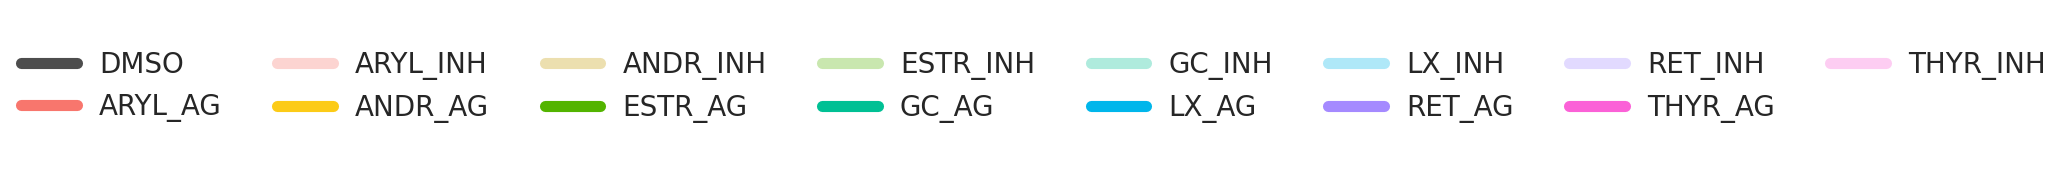

In [89]:
labels = list(color_palette.keys())
handles = [plt.Line2D([0], [0], color=color_palette[label], lw=8) for label in labels]

fig, ax = plt.subplots(figsize=(8, 2))
legend = ax.legend(
    handles, labels, loc='center', ncol=int(np.ceil(len(labels)/2)), frameon=False,
    bbox_to_anchor=(0.5, 0.5)
)
ax.axis('off')
plt.tight_layout()

plt.savefig('../../endpoints_figures/color_palette_legend.pdf', dpi=300, bbox_inches='tight')

# Load manual checks

In [90]:
blank_mix1 = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/single_tif_scanregion/*0136*.tif')
blank_mix1 = [f.split('/')[-1].split('.')[0] for f in blank_mix1]
blank_mix2 = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/single_tif_scanregion/*0145*.tif')
blank_mix2 = [f.split('/')[-1].split('.')[0] for f in blank_mix2]

In [91]:
check_qc_ch1 = pd.read_csv('../../preprocessing/tables/Treshold_QC_check - Channel1_no_dup.csv')
check_qc_ch2 = pd.read_csv('../../preprocessing/tables/Treshold_QC_check - Channel2_no_dup.csv')

In [92]:
check_qc_ch1['general QC (keep or not)'] = check_qc_ch1['general QC (keep or not)'].str.upper()
check_qc_ch1['general QC (keep or not)'] = check_qc_ch1['general QC (keep or not)'].replace({'BETTER NOT': 'LIMIT', 'MAYBE': 'LIMIT', 'YES?': 'LIMIT', 'SUS': 'LIMIT', 'NOT SURE': 'LIMIT', 'YES ': 'YES', 'YES - 2 CBO': 'YES'})
check_qc_ch1['general QC (keep or not)'].value_counts().index

Index(['YES', 'LIMIT', 'NO'], dtype='object', name='general QC (keep or not)')

In [93]:
check_qc_ch1['Reference Image Report'] = check_qc_ch1['Reference Image Report'].str.replace('.pdf', '')

In [94]:
check_qc_ch1['Reference Image Report'].value_counts()

Reference Image Report
20240424_manuel_lessi_0148_ScanRegion1_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_2_channel_1    1
                                                         ..
20240424_manuel_lessi_0136_ScanRegion2_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_2_channel_1    1
Name: count, Length: 153, dtype: int64

In [95]:
check_qc_ch2['general QC (keep or not)'] = check_qc_ch2['general QC (keep or not)'].str.upper()
check_qc_ch2['general QC (keep or not)'] = check_qc_ch2['general QC (keep or not)'].replace({'NOT SURE': 'LIMIT', '?': 'LIMIT', 'YES ': 'YES'})
check_qc_ch2['general QC (keep or not)'].value_counts().index

Index(['YES', 'NO', 'LIMIT'], dtype='object', name='general QC (keep or not)')

In [96]:
check_qc_ch2['Reference Image Report'] = check_qc_ch2['Reference Image Report'].str.replace('.pdf', '')

In [97]:
check_qc_ch1['Reference Image Report'].value_counts()

Reference Image Report
20240424_manuel_lessi_0148_ScanRegion1_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_2_channel_1    1
                                                         ..
20240424_manuel_lessi_0136_ScanRegion2_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_2_channel_1    1
Name: count, Length: 153, dtype: int64

In [98]:
check_qc_ch1['ImageName_ScanRegion_Rep'] = check_qc_ch1['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[:7]))
check_qc_ch2['ImageName_ScanRegion_Rep'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[:7]))


In [99]:
to_keep_ch1 = check_qc_ch1[check_qc_ch1['general QC (keep or not)'].isin(['YES', 'LIMIT'])]
to_keep_ch2 = check_qc_ch2[check_qc_ch2['general QC (keep or not)'].isin(['YES', 'LIMIT'])]

len(set(to_keep_ch1['ImageName_ScanRegion_Rep']).intersection(set(to_keep_ch2['ImageName_ScanRegion_Rep'])))

100

In [100]:
len(check_qc_ch1['ImageName_ScanRegion_Rep'])

153

In [101]:
len(check_qc_ch2['ImageName_ScanRegion_Rep'])

275

In [102]:
good_tissue_to_keep_limit = list(set(check_qc_ch1[check_qc_ch1['general QC (keep or not)'].isin(['YES', 'LIMIT'])]['ImageName_ScanRegion_Rep']).union(set(check_qc_ch2[check_qc_ch2['general QC (keep or not)'].isin(['YES', 'LIMIT'])]['ImageName_ScanRegion_Rep'])))

In [103]:
len(good_tissue_to_keep_limit)

245

In [104]:
good_tissue_to_keep_yes = list(set(check_qc_ch1[check_qc_ch1['general QC (keep or not)'].isin(['YES'])]['ImageName_ScanRegion_Rep']).union(set(check_qc_ch2[check_qc_ch2['general QC (keep or not)'].isin(['YES'])]['ImageName_ScanRegion_Rep'])))

In [105]:
len(good_tissue_to_keep_yes)

211

# Load sample sheet

In [106]:
sample_sheet  = pd.read_csv('../../preprocessing/tables/endpoints_ImageAnalysisSampleSheet.csv')
sample_sheet

,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX
0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,ESTR_AG,CTL04E,12,29,1
1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ESTR_AG,CTL08A,12,30,1
2,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ESTR_INH,CTL04E,12,31,1
3,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ANDR_AG,CTL04E,12,33,1
4,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12,32,1
5,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12,34,1
6,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,ANDR_ANT,CTL04E,13,35,1
7,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ARYL_INH,CTL08A,13,40,1
8,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ARYL_INH,CTL04E,13,39,1
9,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ARYL_AG,CTL08A,13,38,1


In [107]:

sample_sheet['ImageName'] = sample_sheet['Path'].apply(lambda x: x.split('\\')[-1].split('.')[0])
sample_sheet['ImageName_ScanRegion'] = sample_sheet['ImageName'] + '_' + sample_sheet['Scan Area']
sample_sheet['Condition_Line'] = sample_sheet['Condition'] + '_' + sample_sheet['Line ']
sample_sheet

,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX,ImageName,ImageName_ScanRegion,Condition_Line
0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,ESTR_AG,CTL04E,12,29,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion0,ESTR_AG_CTL04E
1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ESTR_AG,CTL08A,12,30,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion1,ESTR_AG_CTL08A
2,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ESTR_INH,CTL04E,12,31,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion2,ESTR_INH_CTL04E
3,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ANDR_AG,CTL04E,12,33,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion3,ANDR_AG_CTL04E
4,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12,32,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,ESTR_INH_CTL08A
5,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12,34,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,ANDR_AG_CTL08A
6,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,ANDR_ANT,CTL04E,13,35,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion0,ANDR_ANT_CTL04E
7,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ARYL_INH,CTL08A,13,40,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A
8,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ARYL_INH,CTL04E,13,39,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion2,ARYL_INH_CTL04E
9,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ARYL_AG,CTL08A,13,38,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion3,ARYL_AG_CTL08A


In [108]:
sample_dict= {i:j for i, j in zip(sample_sheet['ImageName_ScanRegion'], sample_sheet['Condition_Line'])}

In [109]:
mix_1_names = sample_sheet[sample_sheet['MIX'] == 1]['ImageName'].tolist()
mix_2_names = sample_sheet[sample_sheet['MIX'] == 2]['ImageName'].tolist()

In [110]:
hormonal_conditions = ['ESTR_AG', 'ESTR_INH', 'ANDR_AG', 'ANDR_INH', 'ARYL_INH',
       'ARYL_AG', 'LX_AG', 'GC_AG', 'LX_INH', 'GC_INH', 'THYR_INH',
       'THYR_AG', 'DMSO', 'RET_AG',
       'RET_INH']
hormonal_conditions.remove('DMSO')
hormonal_conditions.sort()
hormonal_conditions = ['DMSO'] + hormonal_conditions

# Load measurements file names

In [111]:
measurements_files = glob.glob("/group/testa/Project/EndPoints/TPSSU/analysis/measurements/*.csv")
measurements_files_mix_1 = [f for f in measurements_files if any(name in f for name in mix_1_names)]
measurements_files_mix_2 = [f for f in measurements_files if any(name in f for name in mix_2_names)]

In [112]:
mask_file = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/cyto_mask_measures.csv")
mask_file

,Unnamed: 0,area,label,intensity_mean,intensity_min,intensity_max
0,20240424_manuel_lessi_0133_ScanRegion4_rep_0_c...,2415914.0,1.0,8478.139486,5323.0,45060.0
1,20240424_manuel_lessi_0143_ScanRegion0_rep_1_c...,10287703.0,1.0,9564.326972,6720.0,42038.0
2,20240424_manuel_lessi_0133_ScanRegion2_rep_1_c...,3015477.0,1.0,11510.699631,5536.0,49132.0
3,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,6843311.0,1.0,6301.567833,4239.0,34600.0
4,20240424_manuel_lessi_0141_ScanRegion0_rep_2_c...,23305924.0,1.0,5729.083352,3988.0,24114.0
...,...,...,...,...,...,...
278,20240424_manuel_lessi_0145_ScanRegion2_rep_1_c...,35809244.0,1.0,367.353397,340.0,2983.0
279,20240424_manuel_lessi_0134_ScanRegion6_rep_1_c...,NaN,NaN,NaN,NaN,NaN
280,20240424_manuel_lessi_0144_ScanRegion2_rep_1_c...,6015146.0,1.0,7573.352427,4627.0,44177.0
281,20240424_manuel_lessi_0129_ScanRegion5_rep_1_c...,23404593.0,1.0,7714.037972,4597.0,65534.0


In [113]:
mask_file['OriginalImageName'] = mask_file['Unnamed: 0'].apply(lambda x: '_'.join(x.split('_')[0:4]))
mask_file['ImageName_ScanRegion'] = mask_file['Unnamed: 0'].apply(lambda x: '_'.join(x.split('_')[0:5]))
mask_file['ImageName_ScanRegion_Rep'] = mask_file['Unnamed: 0'].apply(lambda x: '_'.join(x.split('_')[0:7]))
mask_file

,Unnamed: 0,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,20240424_manuel_lessi_0133_ScanRegion4_rep_0_c...,2415914.0,1.0,8478.139486,5323.0,45060.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_0
1,20240424_manuel_lessi_0143_ScanRegion0_rep_1_c...,10287703.0,1.0,9564.326972,6720.0,42038.0,20240424_manuel_lessi_0143,20240424_manuel_lessi_0143_ScanRegion0,20240424_manuel_lessi_0143_ScanRegion0_rep_1
2,20240424_manuel_lessi_0133_ScanRegion2_rep_1_c...,3015477.0,1.0,11510.699631,5536.0,49132.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion2,20240424_manuel_lessi_0133_ScanRegion2_rep_1
3,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,6843311.0,1.0,6301.567833,4239.0,34600.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1
4,20240424_manuel_lessi_0141_ScanRegion0_rep_2_c...,23305924.0,1.0,5729.083352,3988.0,24114.0,20240424_manuel_lessi_0141,20240424_manuel_lessi_0141_ScanRegion0,20240424_manuel_lessi_0141_ScanRegion0_rep_2
...,...,...,...,...,...,...,...,...,...
278,20240424_manuel_lessi_0145_ScanRegion2_rep_1_c...,35809244.0,1.0,367.353397,340.0,2983.0,20240424_manuel_lessi_0145,20240424_manuel_lessi_0145_ScanRegion2,20240424_manuel_lessi_0145_ScanRegion2_rep_1
279,20240424_manuel_lessi_0134_ScanRegion6_rep_1_c...,NaN,NaN,NaN,NaN,NaN,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion6,20240424_manuel_lessi_0134_ScanRegion6_rep_1
280,20240424_manuel_lessi_0144_ScanRegion2_rep_1_c...,6015146.0,1.0,7573.352427,4627.0,44177.0,20240424_manuel_lessi_0144,20240424_manuel_lessi_0144_ScanRegion2,20240424_manuel_lessi_0144_ScanRegion2_rep_1
281,20240424_manuel_lessi_0129_ScanRegion5_rep_1_c...,23404593.0,1.0,7714.037972,4597.0,65534.0,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion5,20240424_manuel_lessi_0129_ScanRegion5_rep_1


In [114]:
mask_file_df_mix_1 = mask_file[mask_file.OriginalImageName.isin(mix_1_names)]
mask_file_df_mix_1

,Unnamed: 0,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,20240424_manuel_lessi_0133_ScanRegion4_rep_0_c...,2415914.0,1.0,8478.139486,5323.0,45060.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_0
2,20240424_manuel_lessi_0133_ScanRegion2_rep_1_c...,3015477.0,1.0,11510.699631,5536.0,49132.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion2,20240424_manuel_lessi_0133_ScanRegion2_rep_1
3,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,6843311.0,1.0,6301.567833,4239.0,34600.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1
9,20240424_manuel_lessi_0134_ScanRegion6_rep_0_c...,7147296.0,1.0,5035.728892,2796.0,20250.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion6,20240424_manuel_lessi_0134_ScanRegion6_rep_0
12,20240424_manuel_lessi_0130_ScanRegion2_rep_1_c...,5736151.0,1.0,3811.331029,2366.0,59754.0,20240424_manuel_lessi_0130,20240424_manuel_lessi_0130_ScanRegion2,20240424_manuel_lessi_0130_ScanRegion2_rep_1
...,...,...,...,...,...,...,...,...,...
272,20240424_manuel_lessi_0131_ScanRegion2_rep_1_c...,619563.0,1.0,7816.673183,4931.0,56017.0,20240424_manuel_lessi_0131,20240424_manuel_lessi_0131_ScanRegion2,20240424_manuel_lessi_0131_ScanRegion2_rep_1
274,20240424_manuel_lessi_0129_ScanRegion5_rep_2_c...,15482008.0,1.0,5670.165540,3481.0,56907.0,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion5,20240424_manuel_lessi_0129_ScanRegion5_rep_2
277,20240424_manuel_lessi_0133_ScanRegion0_rep_2_c...,10075425.0,1.0,4029.633461,2629.0,41430.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_2
279,20240424_manuel_lessi_0134_ScanRegion6_rep_1_c...,NaN,NaN,NaN,NaN,NaN,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion6,20240424_manuel_lessi_0134_ScanRegion6_rep_1


In [115]:
mask_file_df_mix_2 = mask_file[mask_file.OriginalImageName.isin(mix_2_names)]
mask_file_df_mix_2

,Unnamed: 0,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
1,20240424_manuel_lessi_0143_ScanRegion0_rep_1_c...,10287703.0,1.0,9564.326972,6720.0,42038.0,20240424_manuel_lessi_0143,20240424_manuel_lessi_0143_ScanRegion0,20240424_manuel_lessi_0143_ScanRegion0_rep_1
4,20240424_manuel_lessi_0141_ScanRegion0_rep_2_c...,23305924.0,1.0,5729.083352,3988.0,24114.0,20240424_manuel_lessi_0141,20240424_manuel_lessi_0141_ScanRegion0,20240424_manuel_lessi_0141_ScanRegion0_rep_2
5,20240424_manuel_lessi_0138_ScanRegion3_rep_1_c...,6139706.0,1.0,10728.699008,7679.0,47373.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion3,20240424_manuel_lessi_0138_ScanRegion3_rep_1
6,20240424_manuel_lessi_0140_ScanRegion2_rep_0_c...,2887437.0,1.0,10582.573429,8073.0,32277.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion2,20240424_manuel_lessi_0140_ScanRegion2_rep_0
10,20240424_manuel_lessi_0142_ScanRegion3_rep_0_c...,18501332.0,1.0,8751.319145,6006.0,40819.0,20240424_manuel_lessi_0142,20240424_manuel_lessi_0142_ScanRegion3,20240424_manuel_lessi_0142_ScanRegion3_rep_0
...,...,...,...,...,...,...,...,...,...
266,20240424_manuel_lessi_0139_ScanRegion0_rep_2_c...,16192847.0,1.0,12416.619954,8449.0,52637.0,20240424_manuel_lessi_0139,20240424_manuel_lessi_0139_ScanRegion0,20240424_manuel_lessi_0139_ScanRegion0_rep_2
268,20240424_manuel_lessi_0140_ScanRegion4_rep_1_c...,10125138.0,1.0,6630.255008,3940.0,59013.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion4,20240424_manuel_lessi_0140_ScanRegion4_rep_1
271,20240424_manuel_lessi_0137_ScanRegion4_rep_1_c...,10843902.0,1.0,6203.065238,4195.0,41839.0,20240424_manuel_lessi_0137,20240424_manuel_lessi_0137_ScanRegion4,20240424_manuel_lessi_0137_ScanRegion4_rep_1
273,20240424_manuel_lessi_0142_ScanRegion2_rep_1_c...,2596930.0,1.0,4422.110883,3233.0,18355.0,20240424_manuel_lessi_0142,20240424_manuel_lessi_0142_ScanRegion2,20240424_manuel_lessi_0142_ScanRegion2_rep_1


# Not filtered - only morphological features - PCA on single nuclei

In [116]:
def filter_nuclei(df):
    min_quantile = df['area'].quantile(0.01)
    max_quantile = df['area'].quantile(0.99)
    df = df[(df['area'] > min_quantile) & (df['area'] < max_quantile)]
    return df

In [117]:
tot_df_mix1_ch1 = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_1_ch1_CTIP2.csv")
tot_df_mix2_ch1 = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_2_ch1_NeuN.csv")

morphological_features = ['area', 'eccentricity', 'equivalent_diameter', 'extent',
                                            'major_axis_length', 'minor_axis_length', 'orientation', 'perimeter',
                                            'solidity']

tot_df_mix1_ch1['ImageName_ScanRegion_Rep'] = tot_df_mix1_ch1['ImageName'].apply(lambda x: '_'.join(x.split('_')[0:7]))

print(tot_df_mix1_ch1.shape)
tot_df_mix1_ch1 = tot_df_mix1_ch1.groupby('ImageName_ScanRegion_Rep').apply(filter_nuclei).reset_index(drop=True)
print(tot_df_mix1_ch1.shape)

tot_df_mix1_ch1['label_image'] = tot_df_mix1_ch1['label'].astype('str') + '_' + tot_df_mix1_ch1['ImageName_ScanRegion_Rep'].astype('str')
tot_df_mix1_ch1.set_index('label_image', inplace = True)


(4591259, 21)


/tmp/ipykernel_3750874/3325876105.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tot_df_mix1_ch1 = tot_df_mix1_ch1.groupby('ImageName_ScanRegion_Rep').apply(filter_nuclei).reset_index(drop=True)


(4496846, 21)


In [118]:

tot_df_mix1_ch1 = tot_df_mix1_ch1[morphological_features]

In [119]:
tot_df_mix2_ch1['ImageName_ScanRegion_Rep'] = tot_df_mix2_ch1['ImageName'].apply(lambda x: '_'.join(x.split('_')[0:7]))

print(tot_df_mix2_ch1.shape)
tot_df_mix2_ch1 = tot_df_mix2_ch1.groupby('ImageName_ScanRegion_Rep').apply(filter_nuclei).reset_index(drop=True)
print(tot_df_mix2_ch1.shape)

tot_df_mix2_ch1['label_image'] = tot_df_mix2_ch1['label'].astype('str') + '_' + tot_df_mix2_ch1['ImageName_ScanRegion_Rep'].astype('str')
tot_df_mix2_ch1.set_index('label_image', inplace = True)

(4788573, 21)


/tmp/ipykernel_3750874/531573534.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tot_df_mix2_ch1 = tot_df_mix2_ch1.groupby('ImageName_ScanRegion_Rep').apply(filter_nuclei).reset_index(drop=True)


(4690248, 21)


In [120]:

tot_df_mix2_ch1 = tot_df_mix2_ch1[morphological_features]

In [121]:
tot_df_morphological = pd.concat([tot_df_mix1_ch1, tot_df_mix2_ch1], axis=0)

tot_df_morphological['ImageName_ScanRegion_Rep'] = tot_df_morphological.reset_index()['label_image'].apply(lambda x: '_'.join(x.split('_')[1:8])).values
tot_df_morphological['ImageName_ScanRegion'] = tot_df_morphological.reset_index()['label_image'].apply(lambda x: '_'.join(x.split('_')[1:6])).values
tot_df_morphological['Condition_Line'] = tot_df_morphological['ImageName_ScanRegion'].apply(lambda x: sample_dict.get(x, 'Unknown'))
tot_df_morphological['Condition'] = tot_df_morphological['Condition_Line'].apply(lambda x: x.replace('_CTL04E', '').replace('_CTL08A', ''))
tot_df_morphological['Line'] = tot_df_morphological['Condition_Line'].apply(lambda x: x.split('_')[-1])

tot_df_morphological = tot_df_morphological[tot_df_morphological['Condition'].isin(hormonal_conditions)]


In [122]:

tot_df_morphological = tot_df_morphological[tot_df_morphological['ImageName_ScanRegion_Rep'].isin(good_tissue_to_keep_limit)]

tot_df_morphological = tot_df_morphological[tot_df_morphological["ImageName_ScanRegion_Rep"] != "20240424_manuel_lessi_0134_ScanRegion7_rep_1"] # outlier
tot_df_morphological = tot_df_morphological[tot_df_morphological['Condition'] != 'Unknown']  # filter out unknown conditions

In [123]:
features = tot_df_morphological[morphological_features]

In [124]:
len(tot_df_morphological["ImageName_ScanRegion_Rep"].unique())

139

In [125]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA()  
principal_components = pca.fit_transform(features_scaled)


# Add the principal components to the dataframe
for i in range(principal_components.shape[1]):
    tot_df_morphological[f'PC{i+1}'] = principal_components[:, i]


# Extract the most important features for PCA1 and PCA2
pca_components = pd.DataFrame(pca.components_, columns=features.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])
important_features_pca1 = pca_components.loc['PC1'].abs().sort_values(ascending=False).head(5)
important_features_pca2 = pca_components.loc['PC2'].abs().sort_values(ascending=False).head(5)
important_features_pca3 = pca_components.loc['PC3'].abs().sort_values(ascending=False).head(5)

print("Top 5 features contributing to PCA1:")
print(important_features_pca1)

print("\nTop 5 features contributing to PCA2:")
print(important_features_pca2)

print("\nTop 5 features contributing to PCA3:")
print(important_features_pca3)

Top 5 features contributing to PCA1:
equivalent_diameter    0.451671
perimeter              0.446028
area                   0.445225
major_axis_length      0.430577
minor_axis_length      0.424077
Name: PC1, dtype: float64

Top 5 features contributing to PCA2:
extent               0.637839
solidity             0.531573
eccentricity         0.499679
major_axis_length    0.179739
minor_axis_length    0.132653
Name: PC2, dtype: float64

Top 5 features contributing to PCA3:
orientation          0.999614
solidity             0.023722
eccentricity         0.010693
extent               0.009049
major_axis_length    0.002369
Name: PC3, dtype: float64


In [126]:
grouped_df = tot_df_morphological.groupby('ImageName_ScanRegion_Rep').mean(['PC1', 'PC2']).reset_index()

In [127]:
grouped_df['ImageName_ScanRegion'] = grouped_df['ImageName_ScanRegion_Rep'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
grouped_df['Condition_Line'] = grouped_df['ImageName_ScanRegion'].apply(lambda x: sample_dict.get(x, 'Unknown'))
grouped_df['Condition'] = grouped_df['Condition_Line'].apply(lambda x: x.replace('_CTL04E', '').replace('_CTL08A', ''))
grouped_df['Line'] = grouped_df['Condition_Line'].apply(lambda x: x.split('_')[-1])

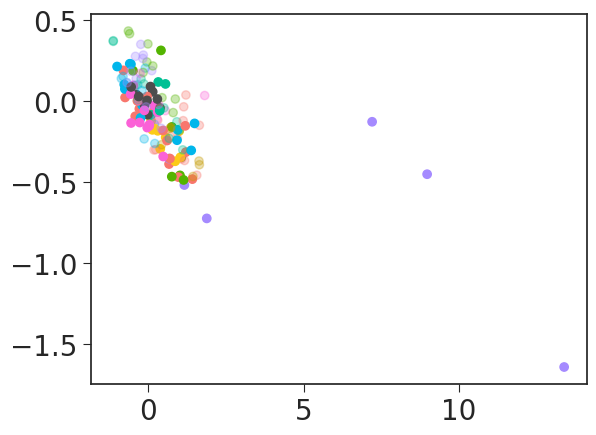

In [128]:
cmap_conditions = plt.matplotlib.colors.ListedColormap([color_palette[c] for c in grouped_df['Condition'].astype('category').cat.categories])

plt.scatter(
    grouped_df['PC1'], grouped_df['PC2'],
    #alpha=0.3,
    c=grouped_df['Condition'].astype('category').cat.codes,
    cmap=cmap_conditions
)

#plt.savefig('./endpoints_figures/endpoints_PCA.pdf', dpi = 300)

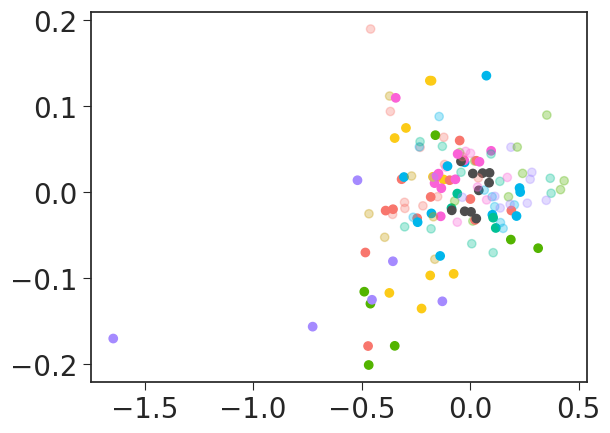

In [129]:
plt.scatter(
    grouped_df['PC2'], grouped_df['PC3'],
    #alpha=0.3,
    c=grouped_df['Condition'].astype('category').cat.codes,
    cmap=cmap_conditions,
)
#plt.savefig('./endpoints_figures/endpoints_PCA_PC2_PC3.pdf', dpi = 300)

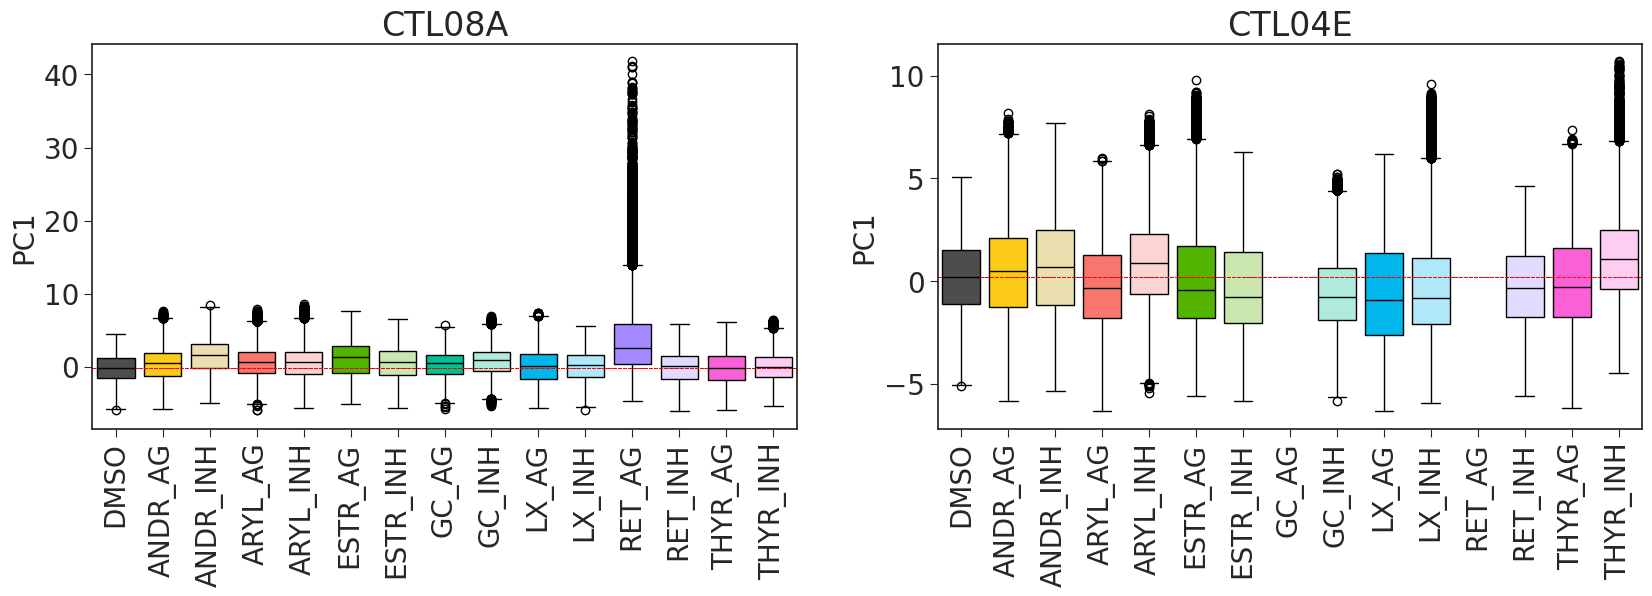

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['PC1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['PC1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC1')
ax[1].set_ylabel('PC1')

plt.savefig('../../endpoints_figures/endpoints_PC1_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC1_all_nuclei.png', dpi=300, bbox_inches='tight')

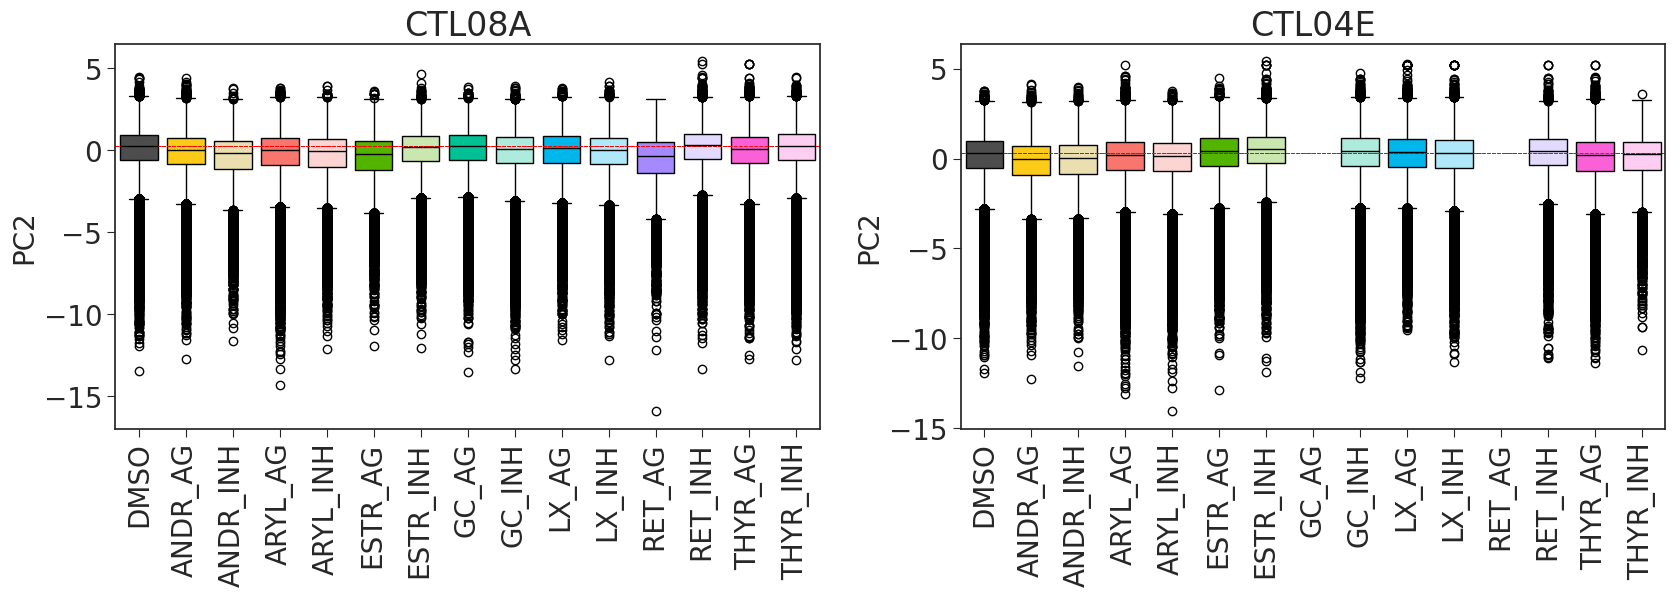

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC2']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['PC2'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC2']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['PC2'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC2')
ax[1].set_ylabel('PC2')

plt.savefig('../../endpoints_figures/endpoints_PC2_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC2_all_nuclei.png', dpi=300, bbox_inches='tight')

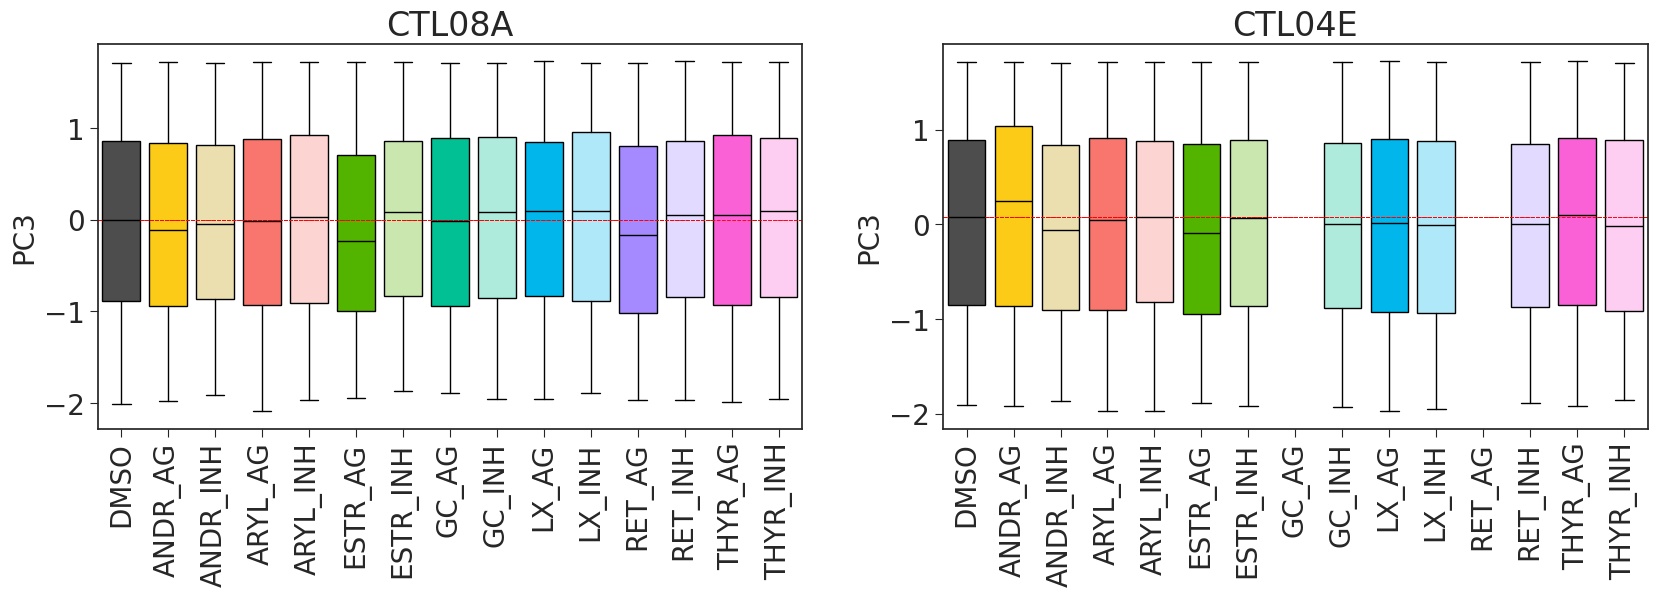

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC3']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['PC3'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['PC3']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['PC3'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC3')
ax[1].set_ylabel('PC3')

plt.savefig('../../endpoints_figures/endpoints_PC3_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC3_all_nuclei.png', dpi=300, bbox_inches='tight')

# Grouped by mean

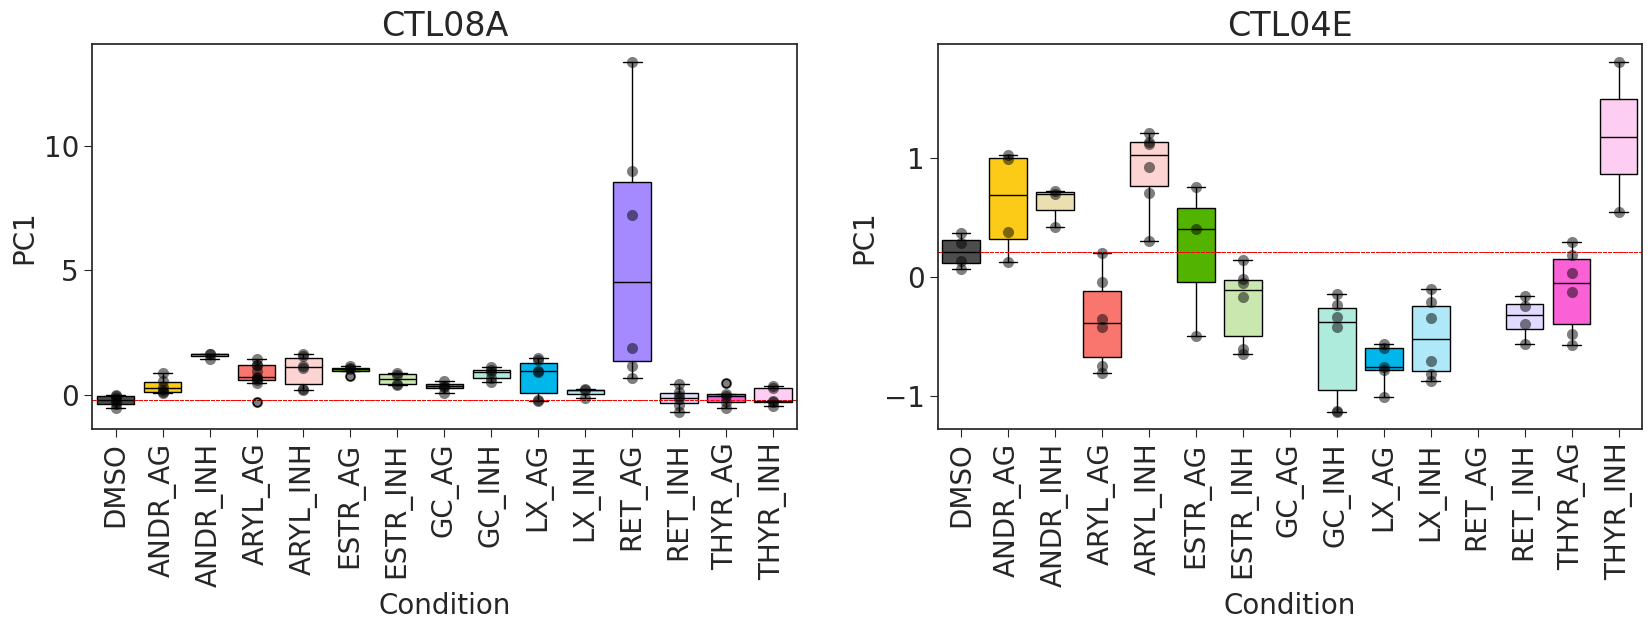

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['PC1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['PC1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL08A')],
    y='PC1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['PC1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['PC1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[grouped_df['Line'] == 'CTL04E'],
    y='PC1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC1')
ax[1].set_ylabel('PC1')

plt.savefig('../../endpoints_figures/endpoints_PC1_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC1_grouped.png', dpi=300, bbox_inches='tight')

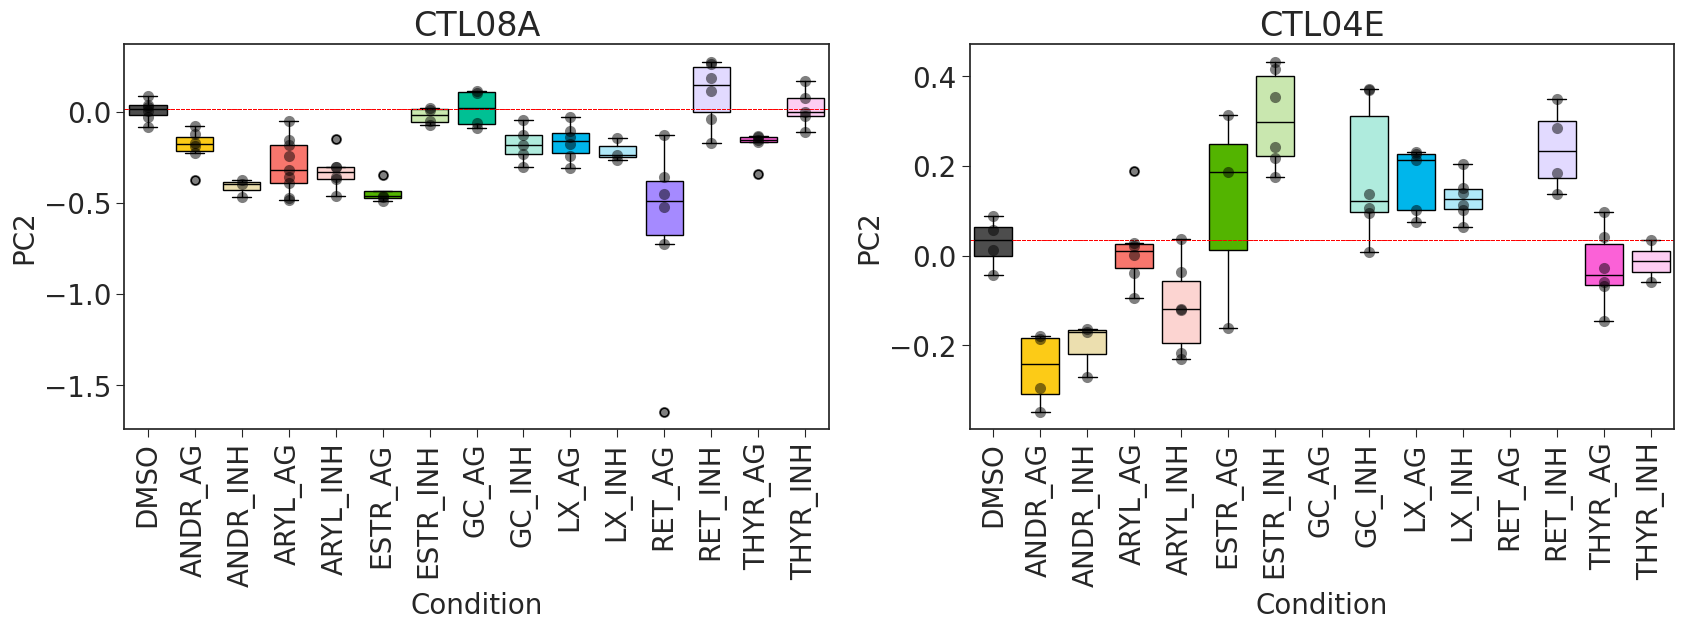

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['PC2']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['PC2'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL08A')],
    y='PC2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['PC2']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['PC2'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL04E')],
    y='PC2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC2')
ax[1].set_ylabel('PC2')

plt.savefig('../../endpoints_figures/endpoints_PC2_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC2_grouped.png', dpi=300, bbox_inches='tight')

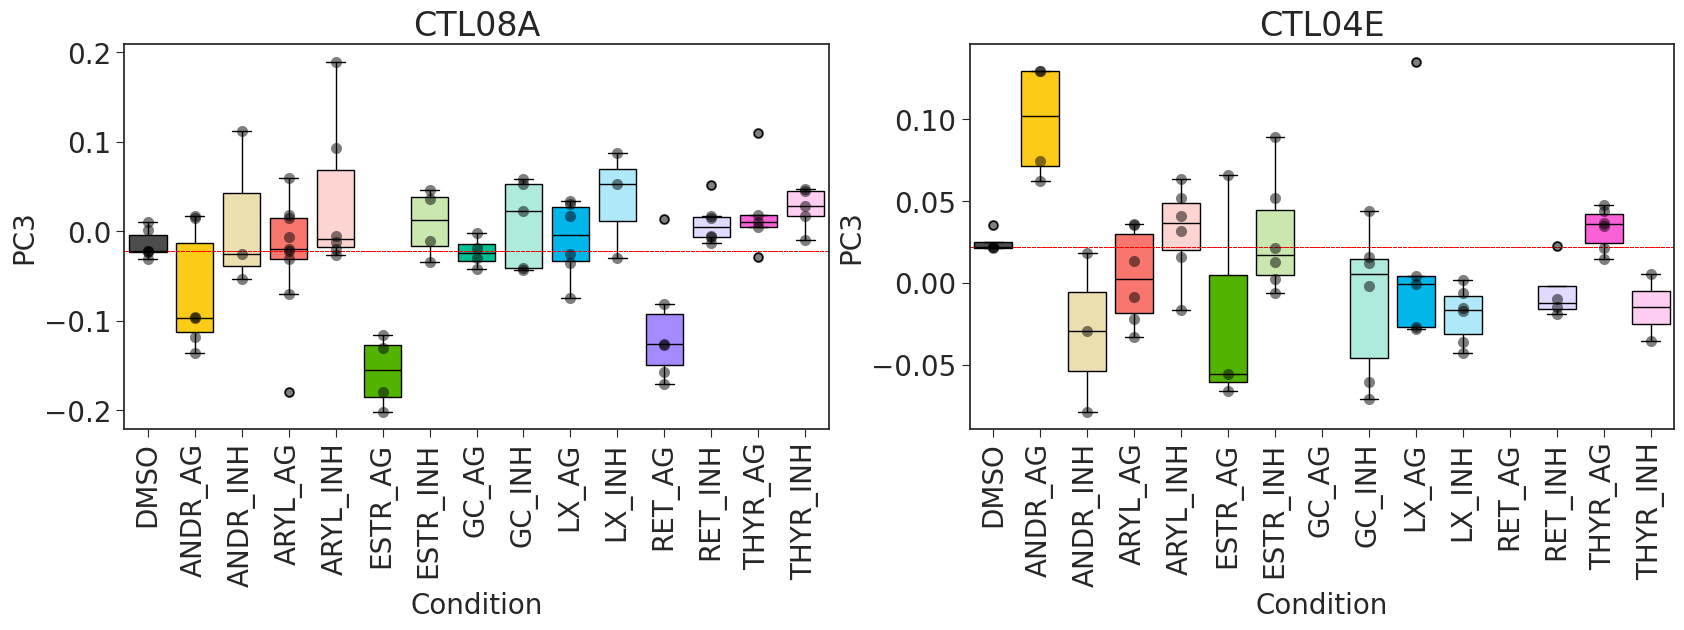

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['PC3']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['PC3'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL08A')],
    y='PC3', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['PC3']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['PC3'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL04E')],
    y='PC3', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('PC3')
ax[1].set_ylabel('PC3')

plt.savefig('../../endpoints_figures/endpoints_PC3_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_PC3_grouped.png', dpi=300, bbox_inches='tight')

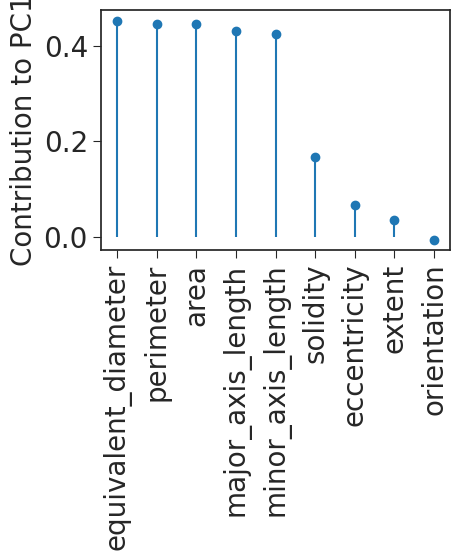

In [136]:
important_features_pca1 = pca_components.loc['PC1'].sort_values(ascending=False)
import matplotlib.pyplot as plt

# Lollipop plot for important_features_pca1
plt.figure(figsize=(5, 6))
x = important_features_pca1.index
y = important_features_pca1.values
plt.stem(x, y, basefmt=" ")
plt.xticks(rotation=90)
plt.ylabel('Contribution to PC1')
plt.tight_layout()
plt.savefig('../../endpoints_figures/important_features_pca1.pdf', dpi=300, bbox_inches='tight')

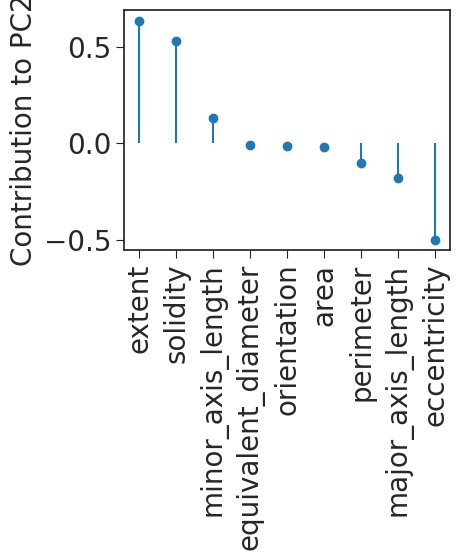

In [137]:
important_features_pca2 = pca_components.loc['PC2'].sort_values(ascending=False)

plt.figure(figsize=(5, 6))
x = important_features_pca2.index
y = important_features_pca2.values
plt.stem(x, y, basefmt=" ")
plt.xticks(rotation=90)
plt.ylabel('Contribution to PC2')
plt.tight_layout()
plt.savefig('../../endpoints_figures/important_features_pca2.pdf', dpi=300, bbox_inches='tight')

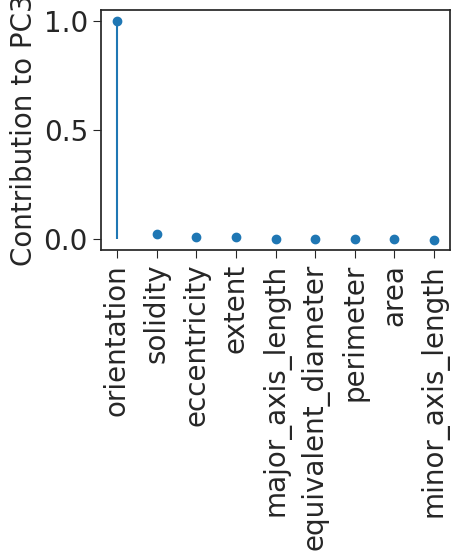

In [138]:
important_features_pca3 = pca_components.loc['PC3'].sort_values(ascending=False)


plt.figure(figsize=(5, 6))
x = important_features_pca3.index
y = important_features_pca3.values
plt.stem(x, y, basefmt=" ")
plt.xticks(rotation=90)
plt.ylabel('Contribution to PC3')
plt.tight_layout()
plt.savefig('../../endpoints_figures/important_features_pca3.pdf', dpi=300, bbox_inches='tight')

# Plot of equivalent diameter

Main contributor of variance for PC1

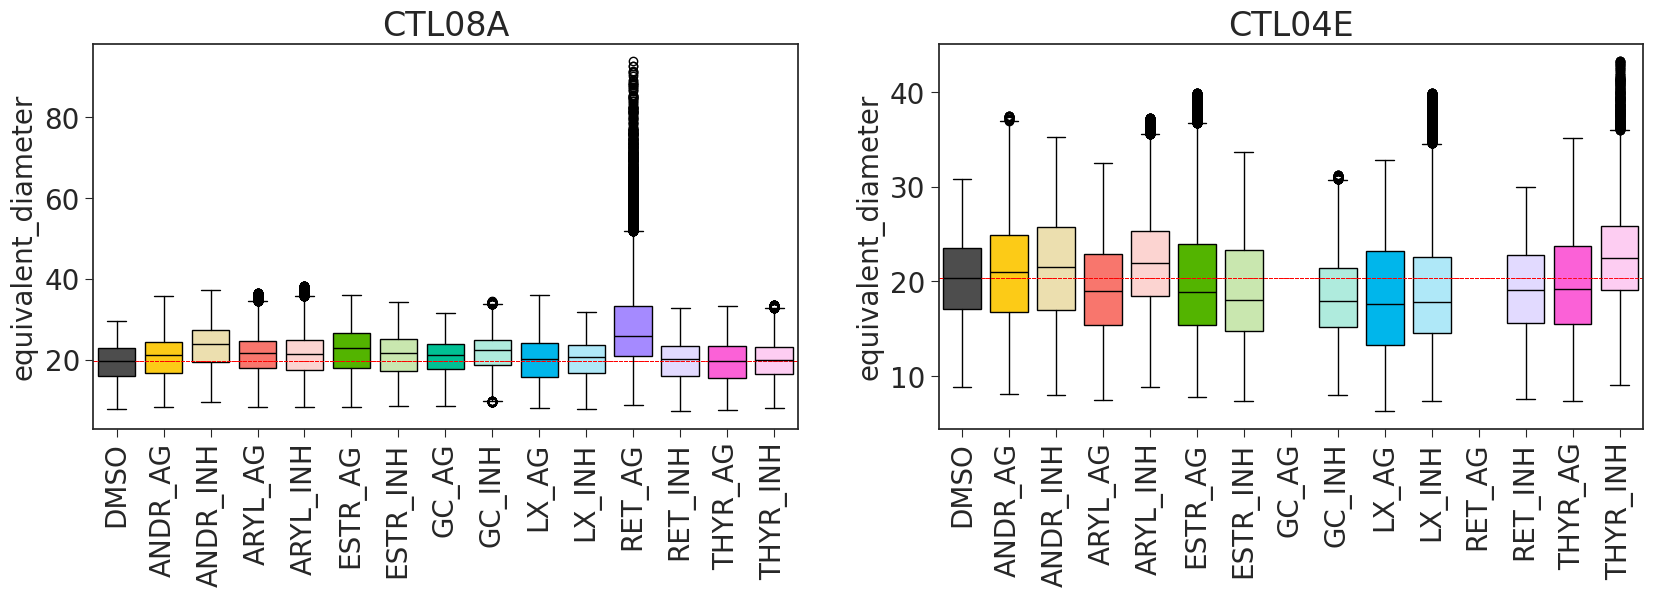

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['equivalent_diameter']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['equivalent_diameter'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['equivalent_diameter']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['equivalent_diameter'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('equivalent_diameter')
ax[1].set_ylabel('equivalent_diameter')

plt.savefig('../../endpoints_figures/endpoints_equivalent_diameter_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_equivalent_diameter_all_nuclei.png', dpi=300, bbox_inches='tight')

## Grouped by mean per organoid

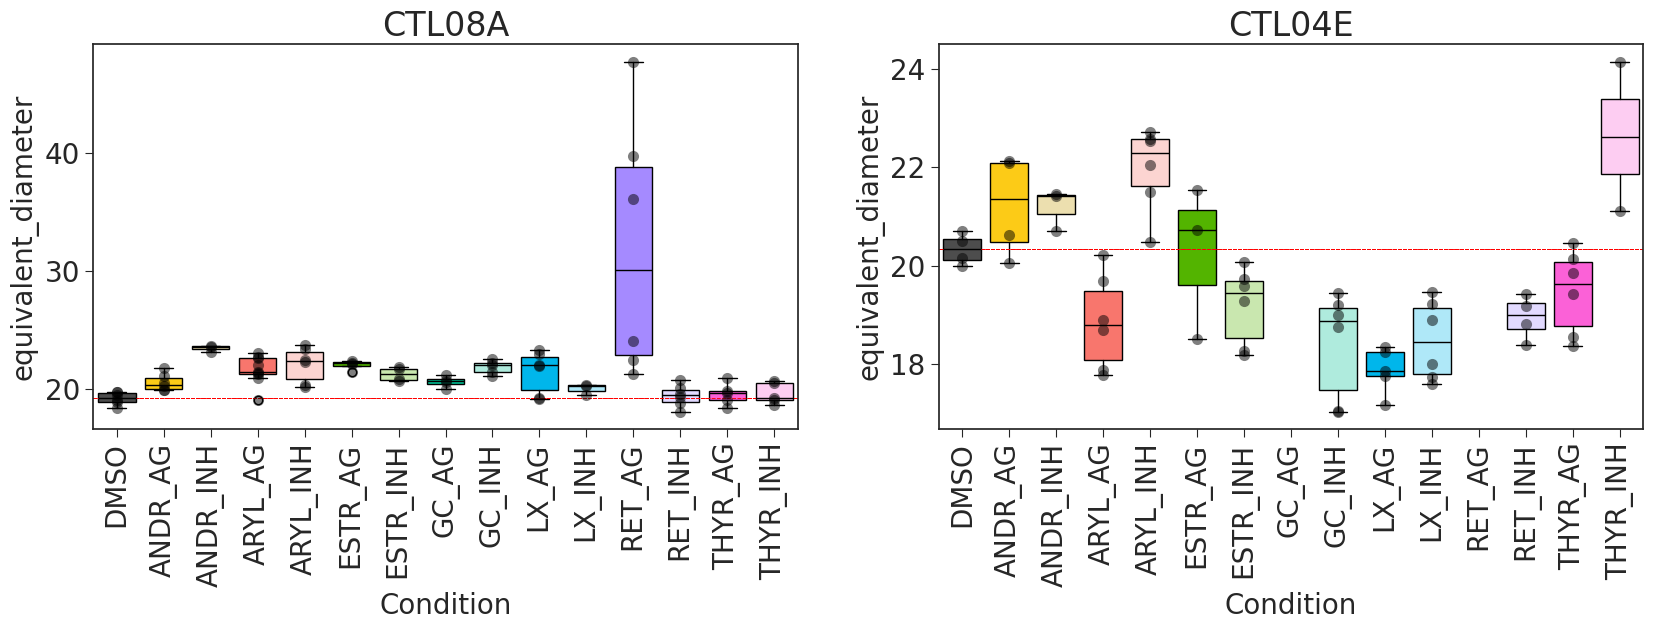

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['equivalent_diameter']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['equivalent_diameter'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL08A')],
    y='equivalent_diameter', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['equivalent_diameter']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['equivalent_diameter'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL04E')],
    y='equivalent_diameter', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('equivalent_diameter')
ax[1].set_ylabel('equivalent_diameter')

plt.savefig('../../endpoints_figures/endpoints_equivalent_diameter_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_equivalent_diameter_grouped.png', dpi=300, bbox_inches='tight')

# Plot of extent

Main contributor of variance for PC2

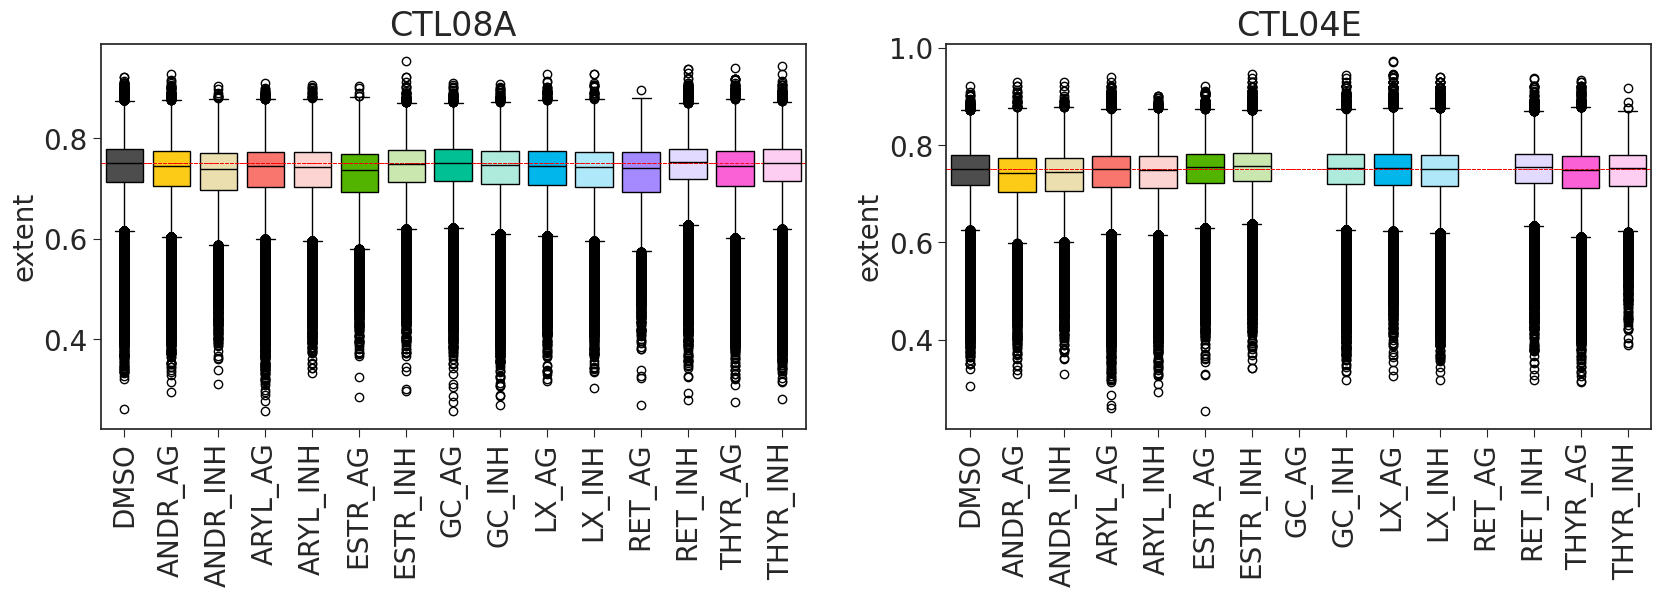

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['extent']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['extent'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['extent']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['extent'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('extent')
ax[1].set_ylabel('extent')

plt.savefig('../../endpoints_figures/endpoints_extent_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_extent_all_nuclei.png', dpi=300, bbox_inches='tight')

## Grouped by mean per organoid

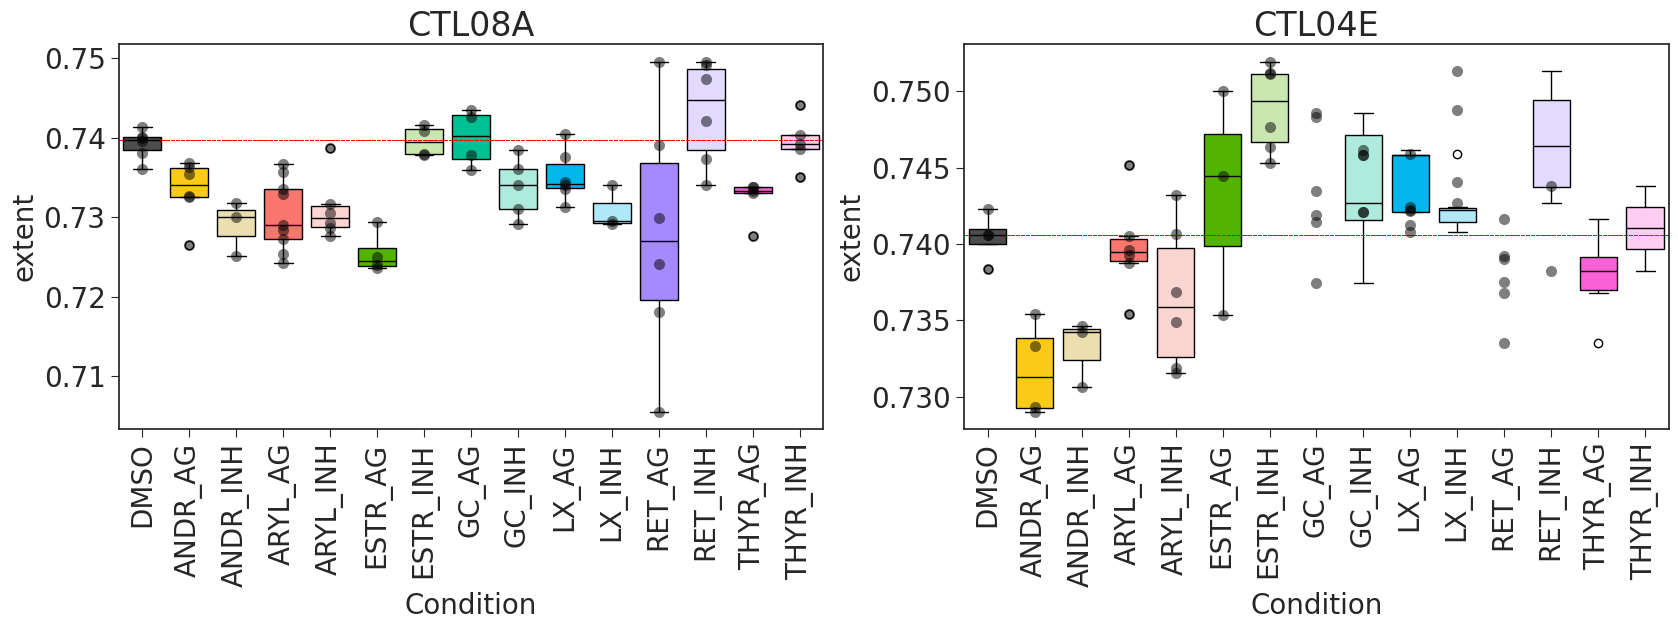

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['extent']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['extent'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL08A') & (grouped_df['Condition'] == cond)],
        y='extent', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
    )

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['extent']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['extent'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL04E') & (grouped_df['Condition'] == cond)],
        y='extent', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
    )

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('extent')
ax[1].set_ylabel('extent')

plt.savefig('../../endpoints_figures/endpoints_extent_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_extent_grouped.png', dpi=300, bbox_inches='tight')

# Plot of eccentricity

Main contributor of variance for PC2

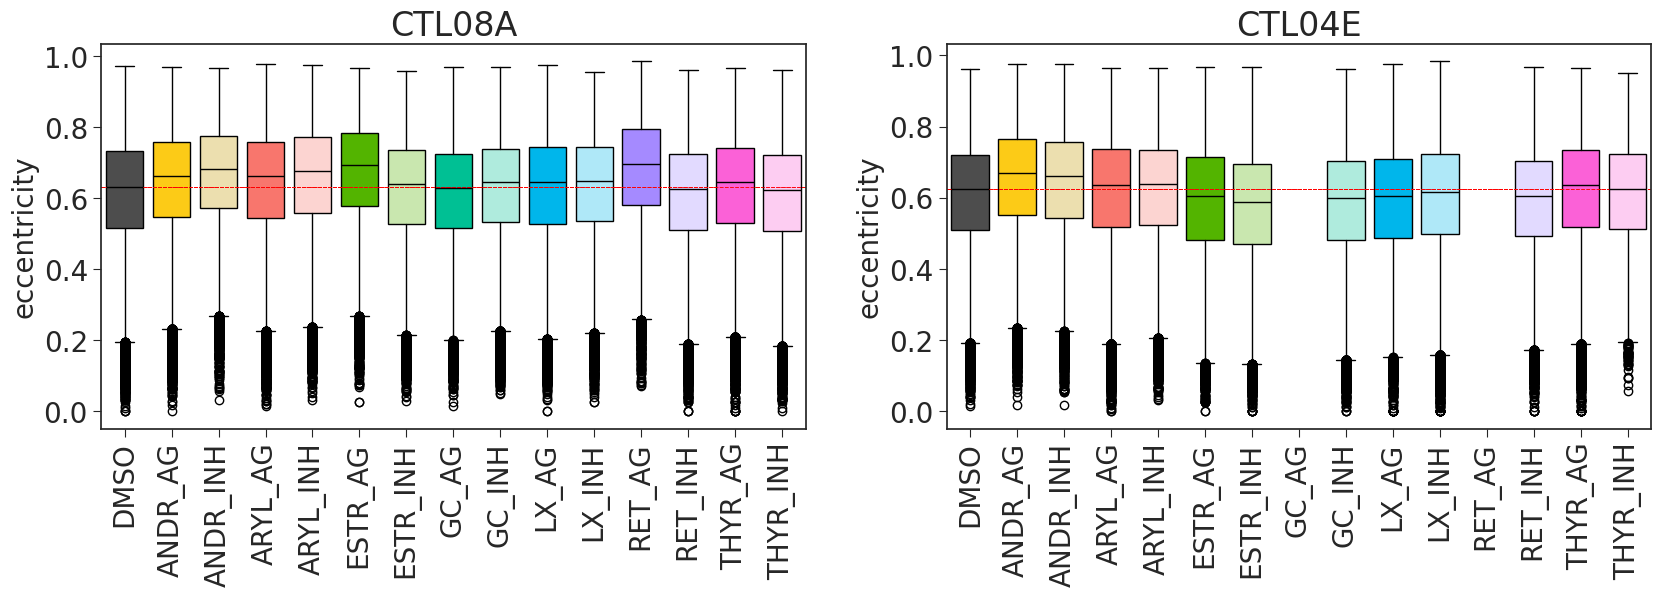

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['eccentricity']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['eccentricity'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['eccentricity']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['eccentricity'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('eccentricity')
ax[1].set_ylabel('eccentricity')

plt.savefig('../../endpoints_figures/endpoints_eccentricity_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_eccentricity_all_nuclei.png', dpi=300, bbox_inches='tight')

## Grouped by mean per organoid

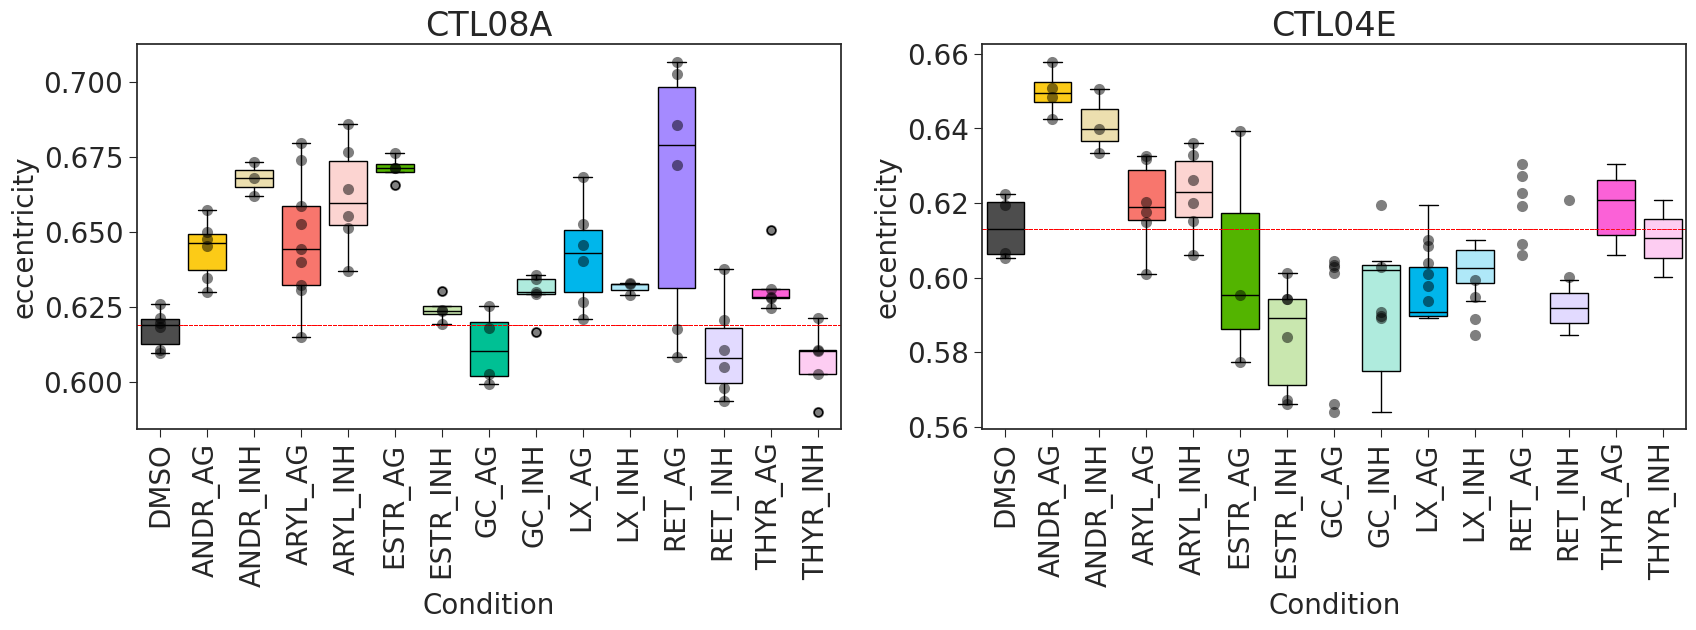

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['eccentricity']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['eccentricity'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL08A') & (grouped_df['Condition'] == cond)],
        y='eccentricity', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
    )

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['eccentricity']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['eccentricity'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL04E') & (grouped_df['Condition'] == cond)],
        y='eccentricity', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
    )

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('eccentricity')
ax[1].set_ylabel('eccentricity')

plt.savefig('../../endpoints_figures/endpoints_eccentricity_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_eccentricity_grouped.png', dpi=300, bbox_inches='tight')

# Plot of orientation

Main contributor of variance for PC3

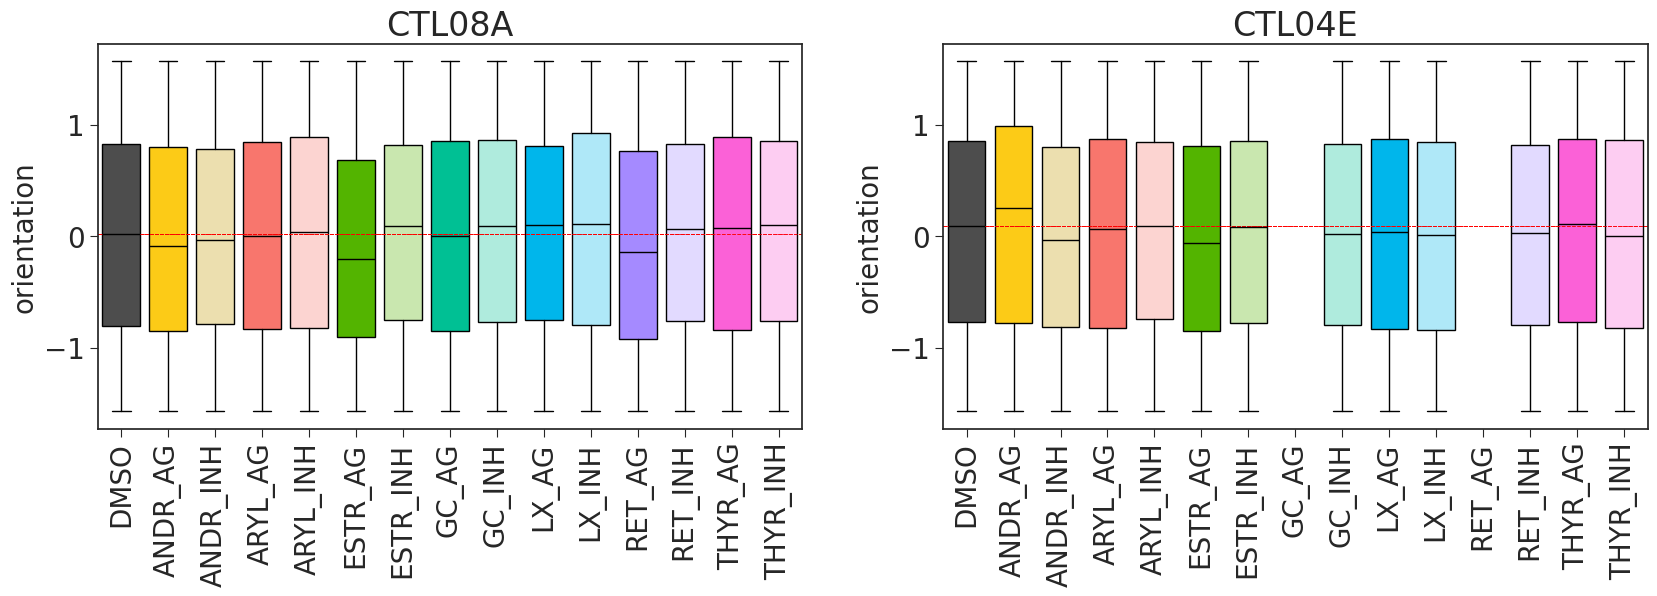

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['orientation']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['orientation'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['orientation']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['orientation'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('orientation')
ax[1].set_ylabel('orientation')

plt.savefig('../../endpoints_figures/endpoints_orientation_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_orientation_all_nuclei.png', dpi=300, bbox_inches='tight')

## Grouped by mean per organoid

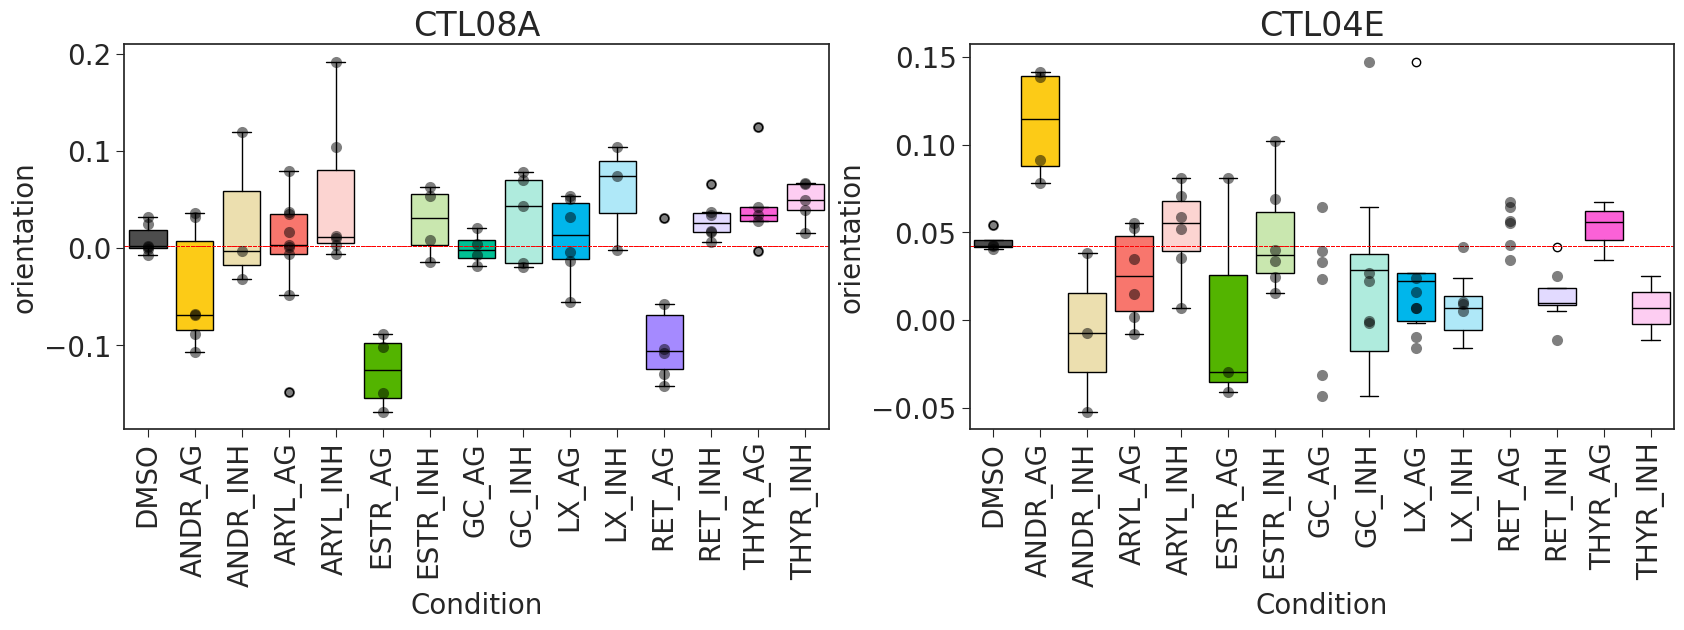

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['orientation']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['orientation'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL08A') & (grouped_df['Condition'] == cond)],
        y='orientation', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
    )

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['orientation']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['orientation'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

    sns.stripplot(
        data=grouped_df[(grouped_df['Line'] == 'CTL04E') & (grouped_df['Condition'] == cond)],
        y='orientation', x='Condition', order=[cond], color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
    )

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('orientation')
ax[1].set_ylabel('orientation')

plt.savefig('../../endpoints_figures/endpoints_orientation_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_orientation_grouped.png', dpi=300, bbox_inches='tight')

# Plot of nuclei area

In [147]:
tot_df_morphological['area_um2'] = tot_df_morphological['area'] * (0.325 ** 2)  # Convert area to um^2

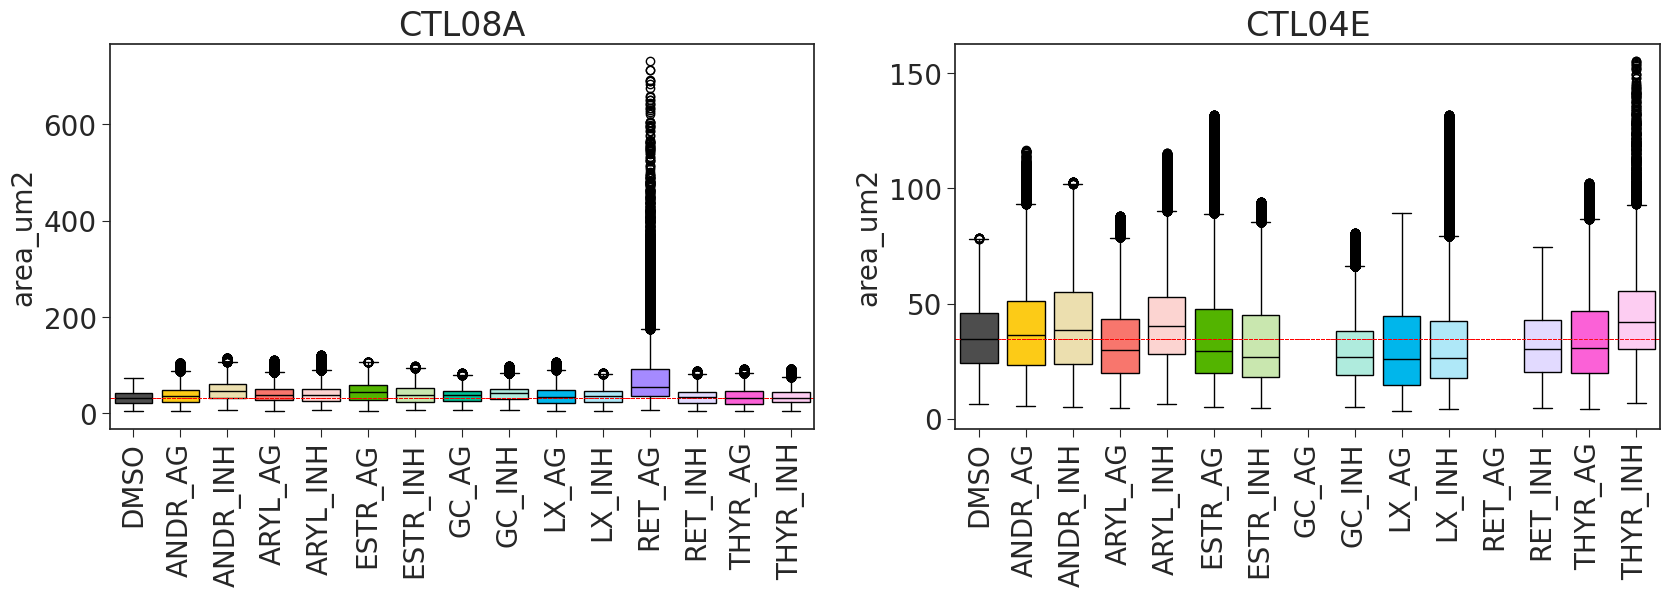

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL08A') & 
                                 (tot_df_morphological['Condition'] == cond)]['area_um2']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL08A')]['area_um2'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

for i, cond in enumerate(hormonal_conditions):
    data = tot_df_morphological[(tot_df_morphological['Line'] == 'CTL04E') & 
                                 (tot_df_morphological['Condition'] == cond)]['area_um2']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = tot_df_morphological[(tot_df_morphological['Condition'] == 'DMSO') & 
                                       (tot_df_morphological['Line'] == 'CTL04E')]['area_um2'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('area_um2')
ax[1].set_ylabel('area_um2')

plt.savefig('../../endpoints_figures/endpoints_area_um2_all_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_area_um2_all_nuclei.png', dpi=300, bbox_inches='tight')

## Grouped by mean per organoid

In [149]:
grouped_df['area_um2'] = grouped_df['area'] * (0.325 ** 2)  # Convert area to um^2

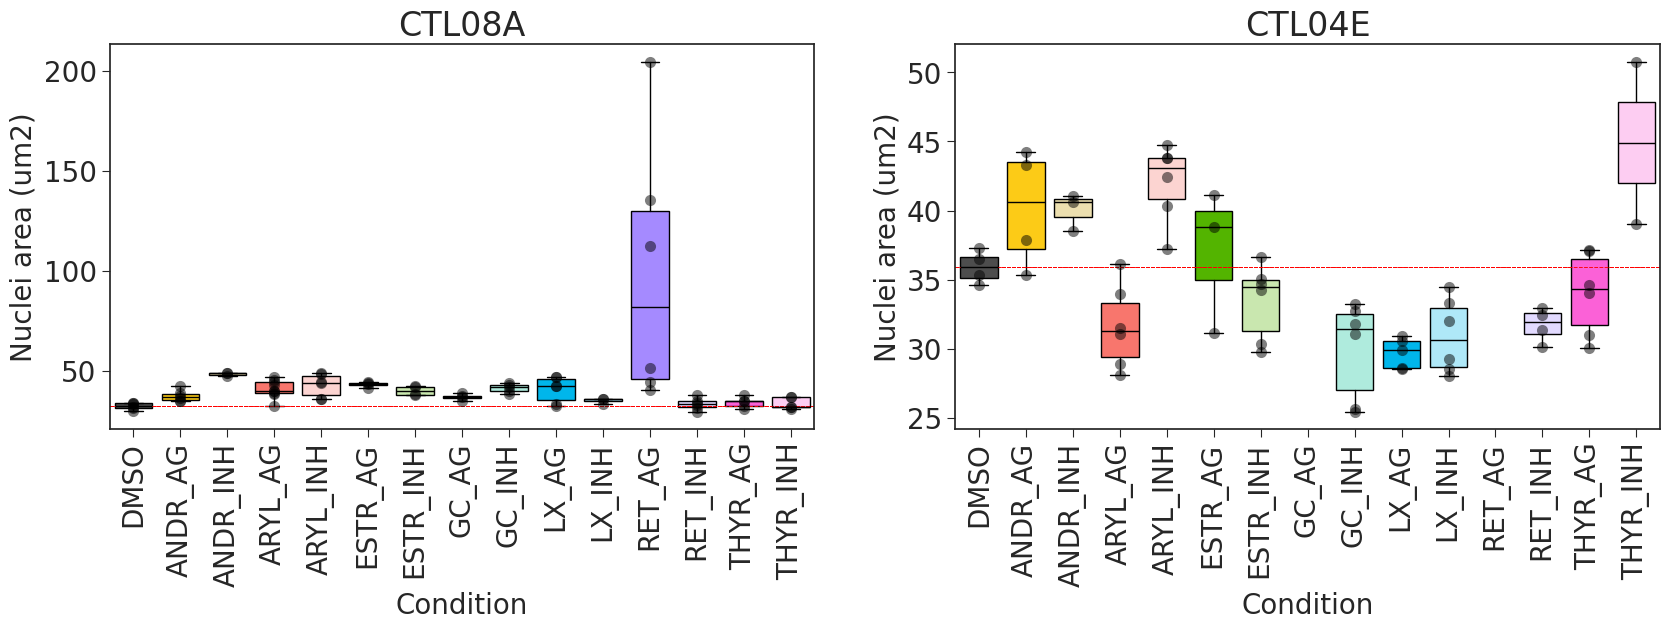

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL08A') & 
                                 (grouped_df['Condition'] == cond)]['area_um2']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL08A')]['area_um2'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL08A')],
    y='area_um2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = grouped_df[(grouped_df['Line'] == 'CTL04E') & 
                                 (grouped_df['Condition'] == cond)]['area_um2']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = grouped_df[(grouped_df['Condition'] == 'DMSO') & 
                                       (grouped_df['Line'] == 'CTL04E')]['area_um2'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=grouped_df[(grouped_df['Line'] == 'CTL04E')],
    y='area_um2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('Nuclei area (um2)')
ax[1].set_ylabel('Nuclei area (um2)')

plt.savefig('../../endpoints_figures/endpoints_area_um2_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_area_um2_grouped.png', dpi=300, bbox_inches='tight')

# Organoid areas

In [151]:
organoid_areas = pd.read_csv('/group/testa/Project/EndPoints/TPSSU/analysis/organoids_area.csv', index_col=0)
organoid_areas

,area
20240424_manuel_lessi_0141_ScanRegion1_rep_0,48618374
20240424_manuel_lessi_0131_ScanRegion0_rep_2,36008220
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522
20240424_manuel_lessi_0143_ScanRegion2_rep_1,61481135
20240424_manuel_lessi_0147_ScanRegion0_rep_1,162545379
...,...
20240424_manuel_lessi_0129_ScanRegion1_rep_0,26572184
20240424_manuel_lessi_0129_ScanRegion0_rep_0,9292198
20240424_manuel_lessi_0142_ScanRegion1_rep_2,38017446
20240424_manuel_lessi_0129_ScanRegion2_rep_1,29459387


In [152]:
organoid_areas['ImageName_ScanRegion'] = organoid_areas.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
organoid_areas['Condition_Line'] = organoid_areas['ImageName_ScanRegion'].map(sample_dict)
organoid_areas['Line'] = organoid_areas['Condition_Line'].apply(lambda x: x.split('_')[-1] if pd.notnull(x) else x)
organoid_areas['Condition'] = organoid_areas['Condition_Line'].str.replace('_CTL08A', '', regex=True)
organoid_areas['Condition'] = organoid_areas['Condition'].str.replace('_CTL04E', '', regex=True)
organoid_areas = organoid_areas[organoid_areas['Condition'].isin(hormonal_conditions)]
organoid_areas

,area,ImageName_ScanRegion,Condition_Line,Line,Condition
20240424_manuel_lessi_0131_ScanRegion0_rep_2,36008220,20240424_manuel_lessi_0131_ScanRegion0,GC_INH_CTL04E,CTL04E,GC_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522,20240424_manuel_lessi_0133_ScanRegion4,RET_AG_CTL08A,CTL08A,RET_AG
20240424_manuel_lessi_0140_ScanRegion4_rep_2,32680044,20240424_manuel_lessi_0140_ScanRegion4,THYR_INH_CTL08A,CTL08A,THYR_INH
20240424_manuel_lessi_0140_ScanRegion0_rep_1,36008064,20240424_manuel_lessi_0140_ScanRegion0,GC_INH_CTL08A,CTL08A,GC_INH
20240424_manuel_lessi_0138_ScanRegion3_rep_1,16957648,20240424_manuel_lessi_0138_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG
...,...,...,...,...,...
20240424_manuel_lessi_0131_ScanRegion4_rep_1,35725975,20240424_manuel_lessi_0131_ScanRegion4,THYR_AG_CTL04E,CTL04E,THYR_AG
20240424_manuel_lessi_0140_ScanRegion3_rep_0,46296832,20240424_manuel_lessi_0140_ScanRegion3,THYR_AG_CTL04E,CTL04E,THYR_AG
20240424_manuel_lessi_0128_ScanRegion4_rep_0,42198648,20240424_manuel_lessi_0128_ScanRegion4,ESTR_INH_CTL08A,CTL08A,ESTR_INH
20240424_manuel_lessi_0129_ScanRegion1_rep_0,26572184,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A,CTL08A,ARYL_INH


In [153]:
organoid_areas['area_um2'] = organoid_areas['area'] * (0.325 ** 2)  # Convert area to um^2

/tmp/ipykernel_3750874/172599718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['area_um2'] = organoid_areas['area'] * (0.325 ** 2)  # Convert area to um^2


In [154]:
summed_area = tot_df_morphological[['ImageName_ScanRegion_Rep', 'area_um2']].groupby('ImageName_ScanRegion_Rep').sum()

In [155]:
organoid_areas['tot_nuclei_areas'] = summed_area

/tmp/ipykernel_3750874/1334222756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['tot_nuclei_areas'] = summed_area


In [156]:
organoid_areas['nuclear_area'] = organoid_areas['tot_nuclei_areas'] / organoid_areas['area_um2'] * 100

/tmp/ipykernel_3750874/3125954352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['nuclear_area'] = organoid_areas['tot_nuclei_areas'] / organoid_areas['area_um2'] * 100


In [157]:
organoid_areas

,area,ImageName_ScanRegion,Condition_Line,Line,Condition,area_um2,tot_nuclei_areas,nuclear_area
20240424_manuel_lessi_0131_ScanRegion0_rep_2,36008220,20240424_manuel_lessi_0131_ScanRegion0,GC_INH_CTL04E,CTL04E,GC_INH,3.803368e+06,1.145734e+06,30.124186
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522,20240424_manuel_lessi_0133_ScanRegion4,RET_AG_CTL08A,CTL08A,RET_AG,8.896289e+05,2.439548e+05,27.422083
20240424_manuel_lessi_0140_ScanRegion4_rep_2,32680044,20240424_manuel_lessi_0140_ScanRegion4,THYR_INH_CTL08A,CTL08A,THYR_INH,3.451830e+06,1.302871e+06,37.744374
20240424_manuel_lessi_0140_ScanRegion0_rep_1,36008064,20240424_manuel_lessi_0140_ScanRegion0,GC_INH_CTL08A,CTL08A,GC_INH,3.803352e+06,1.457129e+06,38.311710
20240424_manuel_lessi_0138_ScanRegion3_rep_1,16957648,20240424_manuel_lessi_0138_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG,1.791152e+06,6.871573e+05,38.363994
...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0131_ScanRegion4_rep_1,35725975,20240424_manuel_lessi_0131_ScanRegion4,THYR_AG_CTL04E,CTL04E,THYR_AG,3.773556e+06,1.162948e+06,30.818358
20240424_manuel_lessi_0140_ScanRegion3_rep_0,46296832,20240424_manuel_lessi_0140_ScanRegion3,THYR_AG_CTL04E,CTL04E,THYR_AG,4.890103e+06,1.751093e+06,35.808912
20240424_manuel_lessi_0128_ScanRegion4_rep_0,42198648,20240424_manuel_lessi_0128_ScanRegion4,ESTR_INH_CTL08A,CTL08A,ESTR_INH,4.457232e+06,1.589967e+06,35.671624
20240424_manuel_lessi_0129_ScanRegion1_rep_0,26572184,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A,CTL08A,ARYL_INH,2.806687e+06,1.140692e+06,40.641951


Text(0, 0.5, 'nuclear_area')

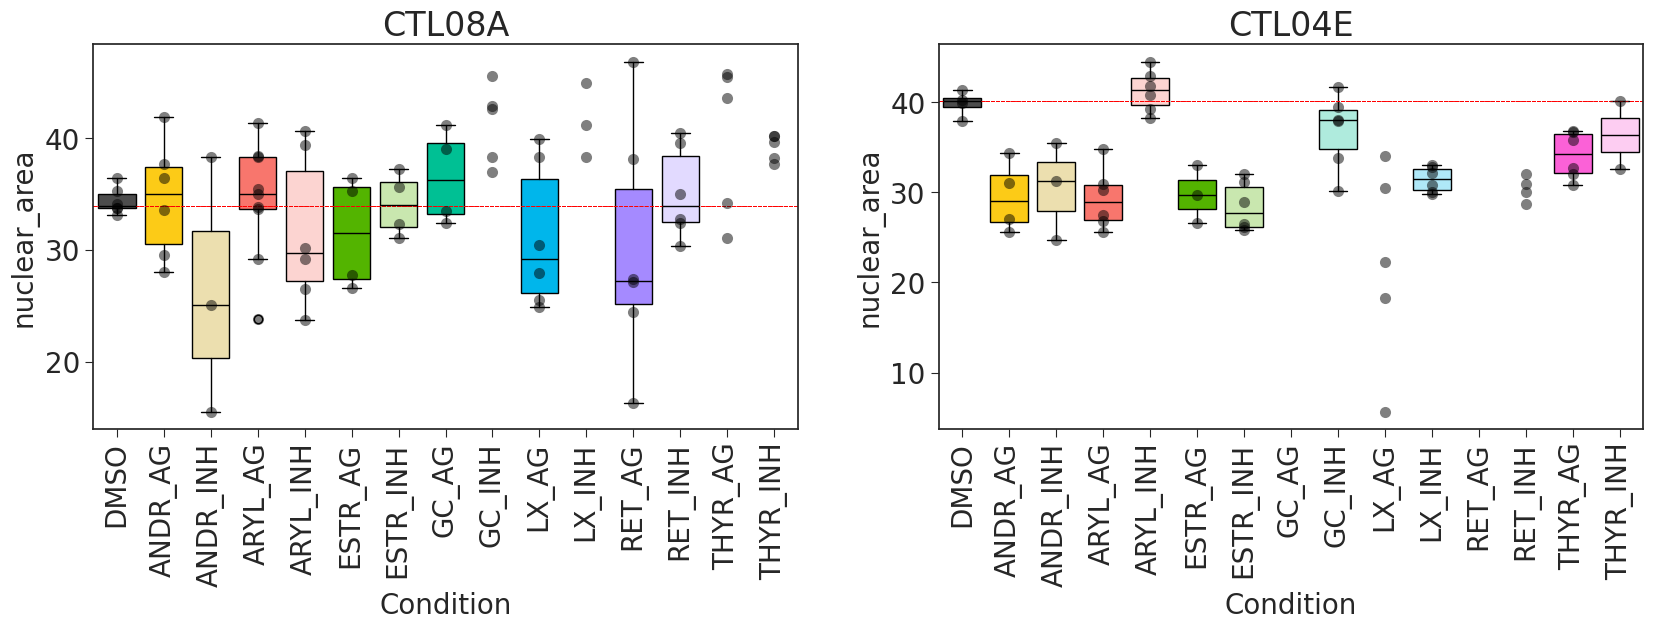

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL08A') & 
                                 (organoid_areas['Condition'] == cond)]['nuclear_area']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL08A')]['nuclear_area'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[(organoid_areas['Line'] == 'CTL08A')],
    y='nuclear_area', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL04E') & 
                                 (organoid_areas['Condition'] == cond)]['nuclear_area']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL04E')]['nuclear_area'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[(organoid_areas['Line'] == 'CTL04E')],
    y='nuclear_area', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('nuclear_area')
ax[1].set_ylabel('nuclear_area')


In [159]:
measurements_files = glob.glob("/group/testa/Project/EndPoints/TPSSU/analysis/measurements/*.csv")
measurements_files_mix_1 = [f for f in measurements_files if any(name in f for name in mix_1_names)]

In [160]:
tot_df_mix1_ch2 = pd.DataFrame()
measurements_files_mix_1_ch2 = [f for f in measurements_files_mix_1 if 'channel_2' in f]

for file in measurements_files_mix_1_ch2:
    print(file)
    df = pd.read_csv(file, index_col=0)
    df['ImageName'] = file.split("/")[-1].split(".")[0]
    print(df.shape)
    tot_df_mix1_ch2 = pd.concat([tot_df_mix1_ch2, df], axis=0)

/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion3_rep_1_channel_2_measures.csv
(14032, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion2_rep_0_channel_2_measures.csv
(36257, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion3_rep_1_channel_2_measures.csv
(29165, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0133_ScanRegion2_rep_0_channel_2_measures.csv
(28234, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion1_rep_2_channel_2_measures.csv
(5186, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion2_rep_1_channel_2_measures.csv
(30598, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion0_rep_0_channel_2_measures.csv
(4420, 19)
/group/testa/Project/EndPoint

In [161]:
tot_pos_SOX2 = {}
density_SOX2 = {}
n_nuclei = {}
n_nuclei_tot_pos_SOX2 = {}
tot_area_SOX2 = {}
tot_area_no_SOX2 = {}

for file in measurements_files_mix_1_ch2:
    #print(file)
    df = pd.read_csv(file, index_col=0)
    
    imageName_scanRegion_rep = file.split('/')[-1].split('.')[0].replace('_channel_2_measures', '')
    imageName_scanRegion = '_'.join(imageName_scanRegion_rep.split('_')[:5])
    
    if imageName_scanRegion_rep in good_tissue_to_keep_limit and imageName_scanRegion in sample_sheet['ImageName_ScanRegion'].values:
        
        df['ImageName'] = file.split("/")[-1].split(".")[0]
        tot_pos_SOX2[file.split("/")[-1].split(".")[0]] = {}
        density_SOX2[imageName_scanRegion_rep] = {}
        n_nuclei_tot_pos_SOX2[imageName_scanRegion_rep] = {}

        df['area_um2'] = df['area'] * (0.325 ** 2)  # Convert area to um^2

        min_quantile = np.quantile(df['area_um2'], 0.01)

        max_quantile = np.quantile(df['area_um2'], 0.99)

        df = df[(df['area_um2'] > min_quantile) & (df['area_um2'] < max_quantile)]

        n_nuclei[file.split("/")[-1].split(".")[0]] = df.shape[0]

        otsu_thrs = filters.threshold_multiotsu(np.array(df['intensity_mean']), classes = 4)

        for i, thr in enumerate(otsu_thrs):
            tot_pos_SOX2[file.split("/")[-1].split(".")[0]][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr) / df.shape[0] * 100
            n_nuclei_tot_pos_SOX2[imageName_scanRegion_rep][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr)

            if i == 1:
                tot_area_SOX2[imageName_scanRegion_rep] = df[df['intensity_mean'] > thr]['area_um2'].sum()
                tot_area_no_SOX2[imageName_scanRegion_rep] = df[df['intensity_mean'] <= thr]['area_um2'].sum()
            

In [162]:
organoid_areas['SOX2_pos_area'] = organoid_areas.index.map(tot_area_SOX2)
organoid_areas['SOX2_neg_area'] = organoid_areas.index.map(tot_area_no_SOX2)

/tmp/ipykernel_3750874/4008132345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['SOX2_pos_area'] = organoid_areas.index.map(tot_area_SOX2)
/tmp/ipykernel_3750874/4008132345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['SOX2_neg_area'] = organoid_areas.index.map(tot_area_no_SOX2)


In [163]:
organoid_areas['SOX2_pos_area_over_tot'] = organoid_areas['SOX2_pos_area'] / organoid_areas['area_um2'] * 100
organoid_areas['SOX2_neg_area_over_tot'] = organoid_areas['SOX2_neg_area'] / organoid_areas['area_um2'] * 100

/tmp/ipykernel_3750874/1300664090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['SOX2_pos_area_over_tot'] = organoid_areas['SOX2_pos_area'] / organoid_areas['area_um2'] * 100
/tmp/ipykernel_3750874/1300664090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['SOX2_neg_area_over_tot'] = organoid_areas['SOX2_neg_area'] / organoid_areas['area_um2'] * 100


Text(0, 0.5, 'nuclear_area/organoid area')

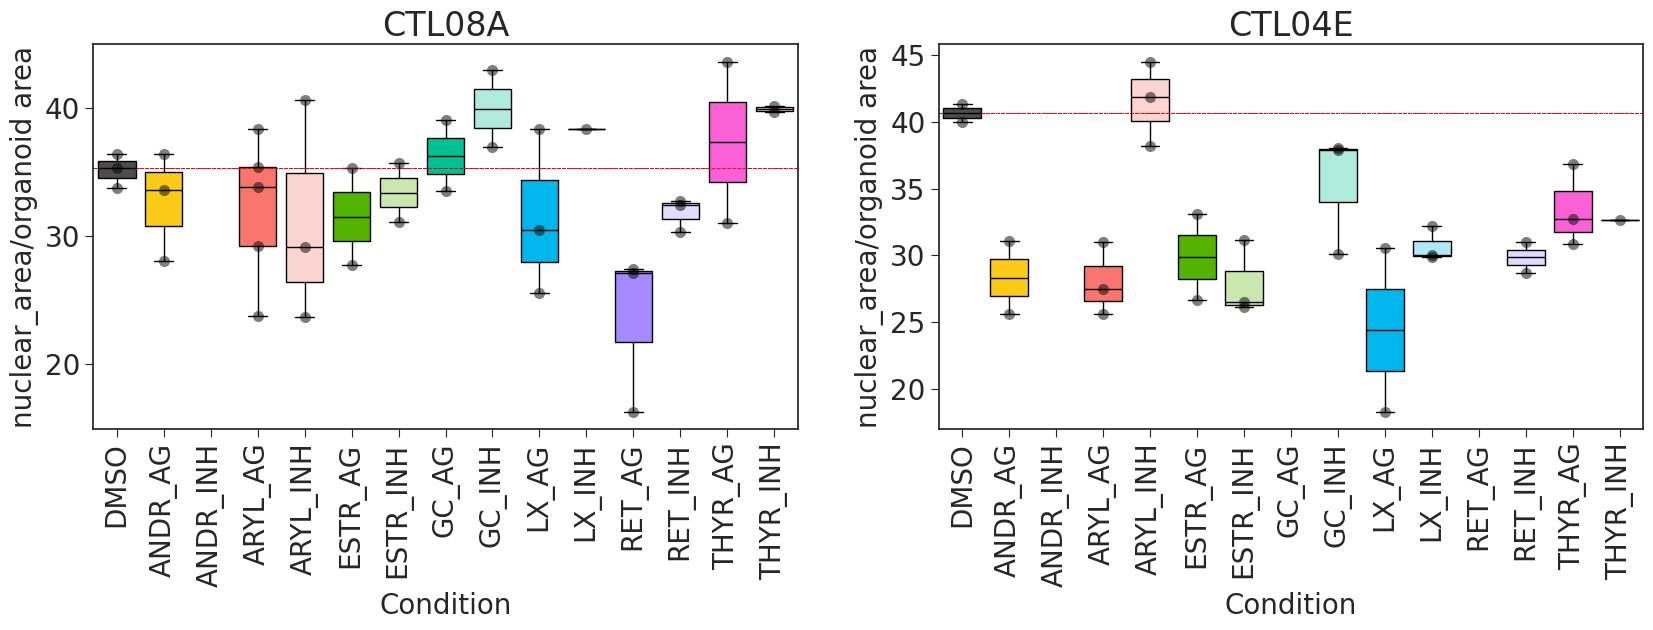

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

organoid_area_mix1 = organoid_areas[~organoid_areas['SOX2_pos_area'].isna()]

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A') & 
                                 (organoid_area_mix1['Condition'] == cond)]['nuclear_area']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL08A')]['nuclear_area'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A')],
    y='nuclear_area', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E') & 
                                 (organoid_area_mix1['Condition'] == cond)]['nuclear_area']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL04E')]['nuclear_area'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E')],
    y='nuclear_area', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('nuclear_area/organoid area')
ax[1].set_ylabel('nuclear_area/organoid area')


Text(0, 0.5, 'SOX2_pos_area_over_tot')

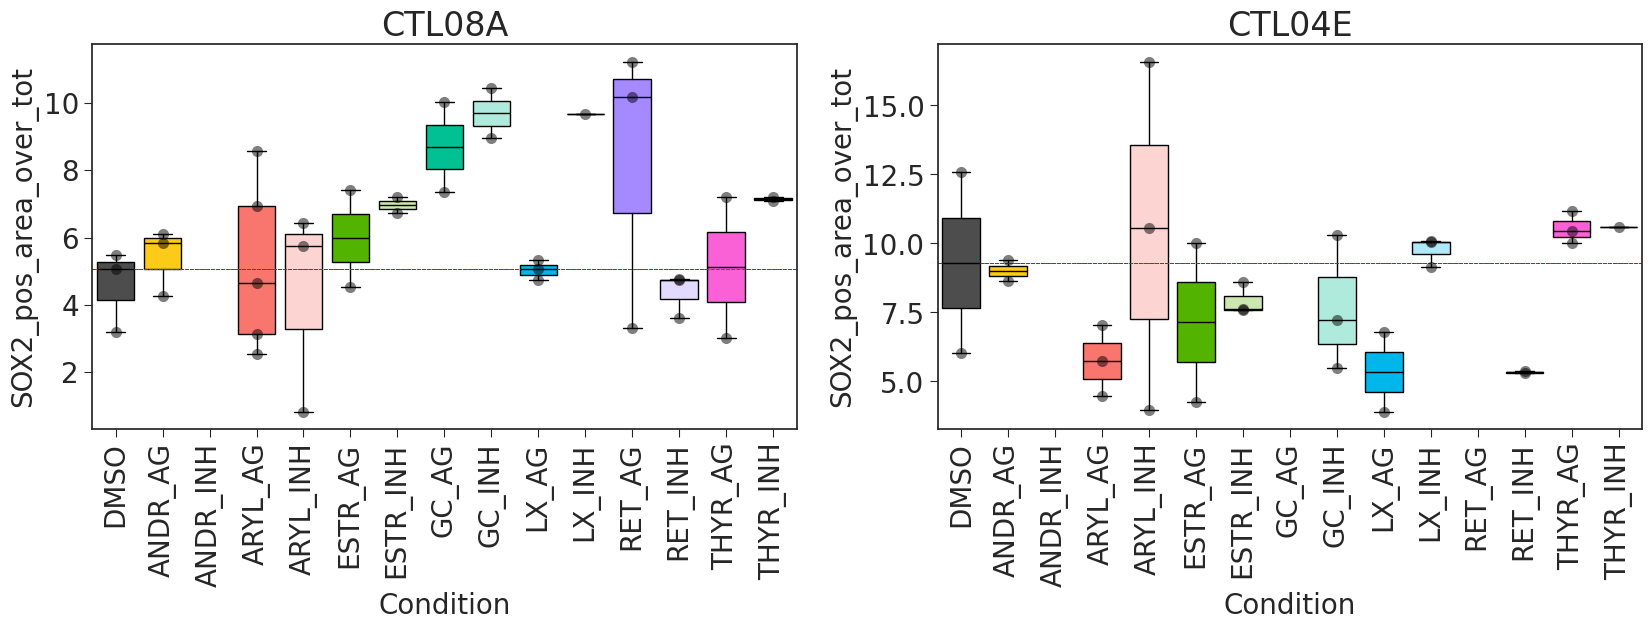

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

organoid_area_mix1 = organoid_areas[~organoid_areas['SOX2_pos_area'].isna()]

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A') & 
                                 (organoid_area_mix1['Condition'] == cond)]['SOX2_pos_area_over_tot']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL08A')]['SOX2_pos_area_over_tot'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A')],
    y='SOX2_pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E') & 
                                 (organoid_area_mix1['Condition'] == cond)]['SOX2_pos_area_over_tot']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL04E')]['SOX2_pos_area_over_tot'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E')],
    y='SOX2_pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2_pos_area_over_tot')
ax[1].set_ylabel('SOX2_pos_area_over_tot')


Text(0, 0.5, 'SOX2_neg_area_over_tot')

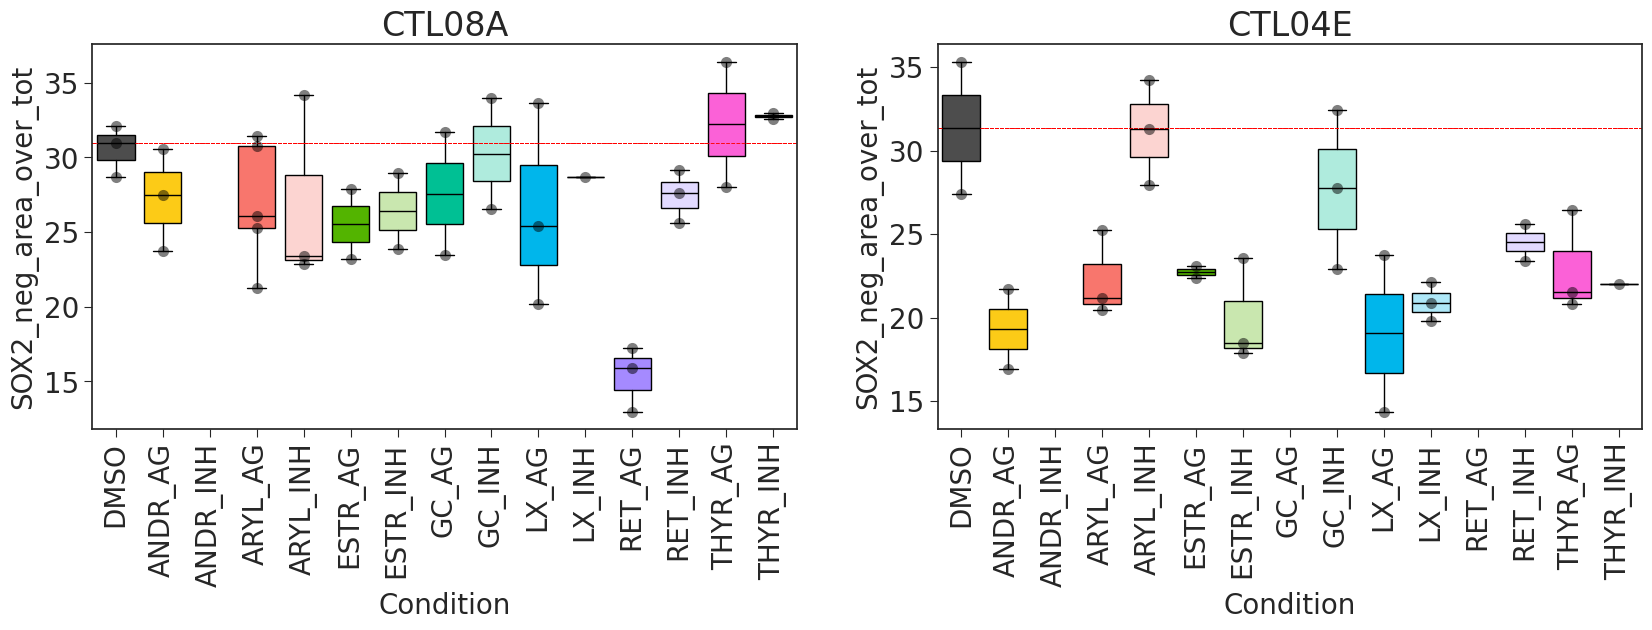

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A') & 
                                 (organoid_area_mix1['Condition'] == cond)]['SOX2_neg_area_over_tot']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL08A')]['SOX2_neg_area_over_tot'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL08A')],
    y='SOX2_neg_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E') & 
                                 (organoid_area_mix1['Condition'] == cond)]['SOX2_neg_area_over_tot']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_area_mix1[(organoid_area_mix1['Condition'] == 'DMSO') & 
                                       (organoid_area_mix1['Line'] == 'CTL04E')]['SOX2_neg_area_over_tot'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_area_mix1[(organoid_area_mix1['Line'] == 'CTL04E')],
    y='SOX2_neg_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2_neg_area_over_tot')
ax[1].set_ylabel('SOX2_neg_area_over_tot')
